In [1]:
import os
import warnings
base_path = os.path.abspath("../")
os.chdir(base_path)
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from lime import lime_tabular
import eli5
import shap
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

/anaconda2/envs/python3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [3]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
# Crude way of generating multi-treatment, so ATE/feature importances are NOT meant to be interpreted below
w_multi = np.array(['treatment_A', 'treatment_B', 'treatment_C', 'control'] * int(n_samples/4))
e_multi = {x: e for x in w_multi}
assert w_multi.shape[0] == n_samples

## S Learner

In [6]:
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.00947193, 0.01521811, 0.00410694])

### Feature Importance (method = `gini`)

In [7]:
slearner.get_importance(normalize=True, method='gini')

{'treatment_A': Feature_001    0.085333
 Feature_000    0.084000
 Feature_002    0.078000
 Feature_003    0.071667
 Feature_004    0.065333
 Feature_009    0.040333
 Feature_006    0.036000
 Feature_016    0.035333
 Feature_015    0.034000
 Feature_012    0.034000
 Feature_011    0.031667
 Feature_019    0.031667
 Feature_007    0.031333
 Feature_013    0.030667
 Feature_010    0.030333
 Feature_021    0.030333
 Feature_024    0.030000
 Feature_023    0.029667
 Feature_020    0.029333
 Feature_017    0.028667
 Feature_005    0.028667
 Feature_008    0.026333
 Feature_014    0.025000
 Feature_018    0.022333
 Feature_022    0.021000
 dtype: float64, 'treatment_B': Feature_000    0.081667
 Feature_002    0.079333
 Feature_001    0.078333
 Feature_003    0.070667
 Feature_004    0.066667
 Feature_019    0.041000
 Feature_021    0.040667
 Feature_011    0.035667
 Feature_016    0.033333
 Feature_005    0.032667
 Feature_009    0.032000
 Feature_020    0.031667
 Feature_007    0.031333
 Fea

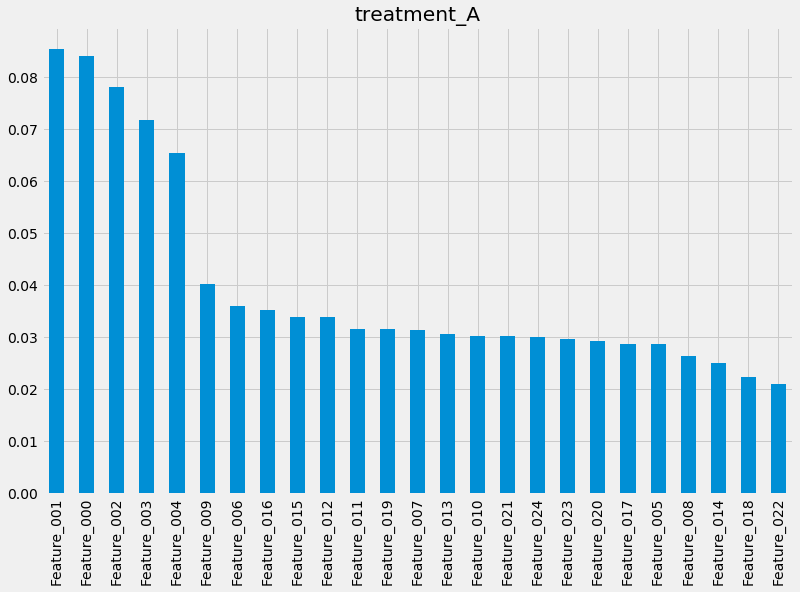

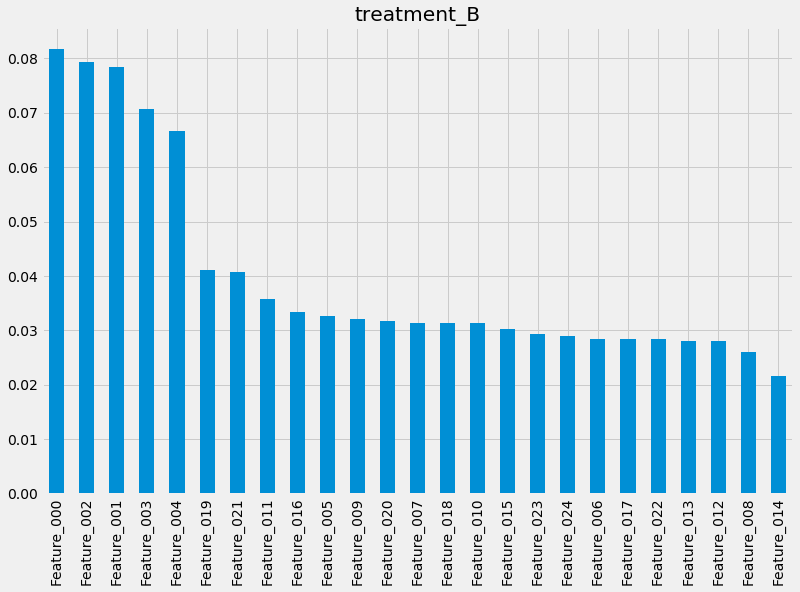

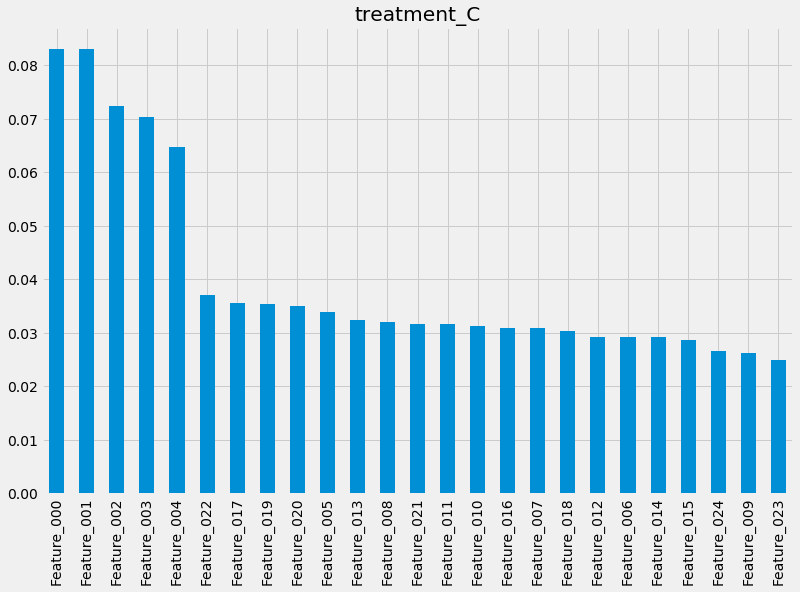

In [8]:
slearner.plot_importance(normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [9]:
slearner.get_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

{'treatment_A': Feature_001    0.490246
 Feature_000    0.442921
 Feature_003    0.340571
 Feature_002    0.105020
 Feature_004    0.099780
 Feature_009    0.022343
 Feature_013    0.020456
 Feature_016    0.019950
 Feature_015    0.019686
 Feature_006    0.019174
 Feature_019    0.018976
 Feature_007    0.018263
 Feature_023    0.017720
 Feature_021    0.017268
 Feature_012    0.016205
 Feature_011    0.016122
 Feature_020    0.016084
 Feature_008    0.014932
 Feature_017    0.014030
 Feature_010    0.014000
 Feature_014    0.013717
 Feature_024    0.012843
 Feature_005    0.011448
 Feature_018    0.010228
 Feature_022    0.008270
 dtype: float64, 'treatment_B': Feature_001    0.484615
 Feature_000    0.417575
 Feature_003    0.336913
 Feature_004    0.110143
 Feature_002    0.105848
 Feature_011    0.022265
 Feature_019    0.022074
 Feature_010    0.021705
 Feature_005    0.019909
 Feature_021    0.019649
 Feature_016    0.019482
 Feature_007    0.018275
 Feature_020    0.017798
 Fea

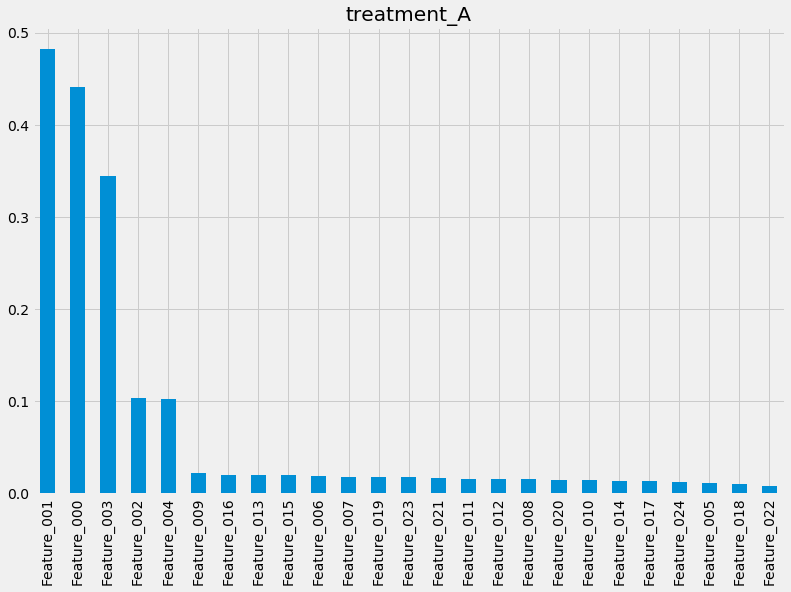

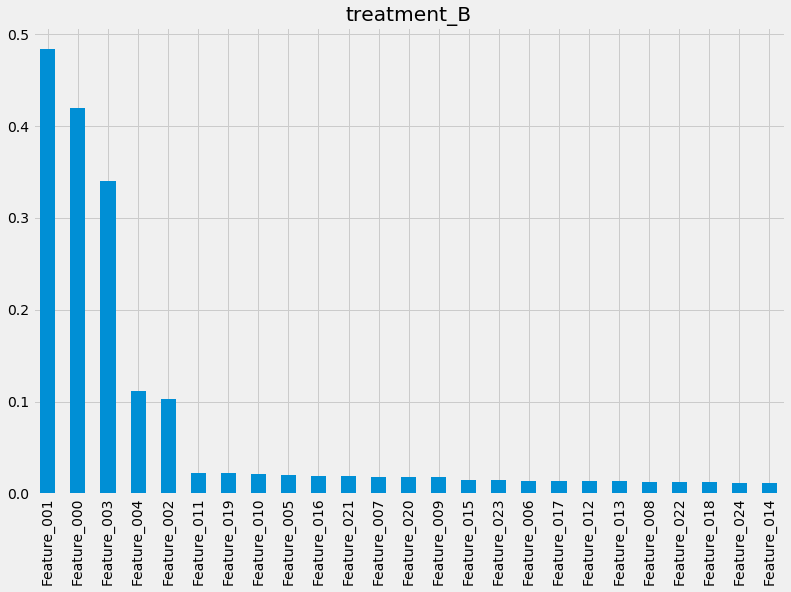

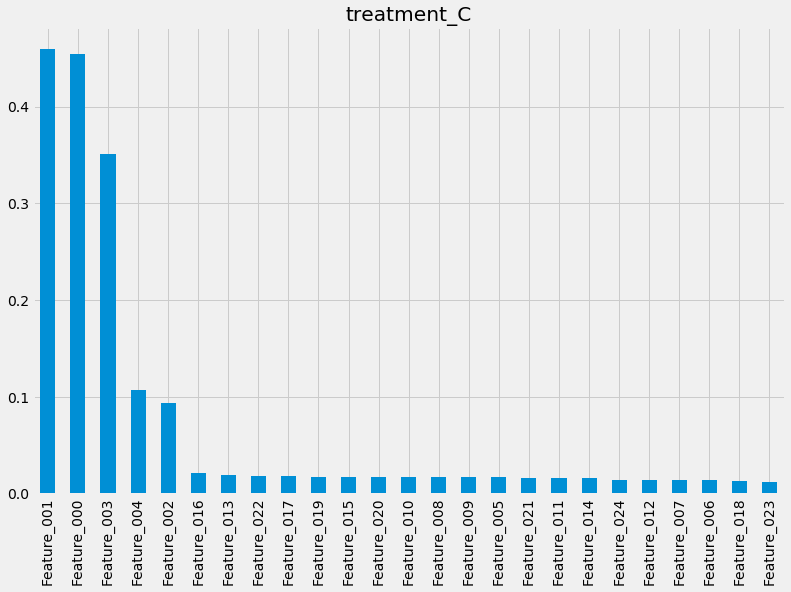

In [10]:
slearner.plot_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

### Shapley Values

In [11]:
shap_slearner = slearner.get_shap_values(X=X, y=y, treatment=w_multi)
shap_slearner

{'treatment_A': array([[ 0.15267485, -0.063434  ,  0.27354942, ...,  0.00785408,
          0.01686953, -0.00176739],
        [ 0.32854043,  0.3547185 , -0.06047642, ...,  0.02040646,
          0.00188747,  0.01382078],
        [ 0.23618635, -0.3288295 , -0.07843226, ...,  0.0099362 ,
         -0.0039005 ,  0.0232283 ],
        ...,
        [ 0.17852426, -0.00801311,  0.01487508, ...,  0.00329518,
          0.00692355,  0.00836998],
        [ 0.06860467,  0.25675453, -0.10892536, ...,  0.00484177,
          0.01433939,  0.01537035],
        [ 0.30829762,  0.1508176 , -0.04775626, ...,  0.00294382,
         -0.00438371,  0.00891649]]),
 'treatment_B': array([[-0.21334654, -0.53635237,  0.09674416, ...,  0.00280448,
          0.01281541, -0.02114595],
        [ 0.27845145,  0.36791053, -0.06062574, ..., -0.00941353,
          0.00779569,  0.01066123],
        [-0.60217863,  0.18674139,  0.09405466, ..., -0.00667374,
         -0.00074423,  0.00841412],
        ...,
        [ 0.12951364,  0

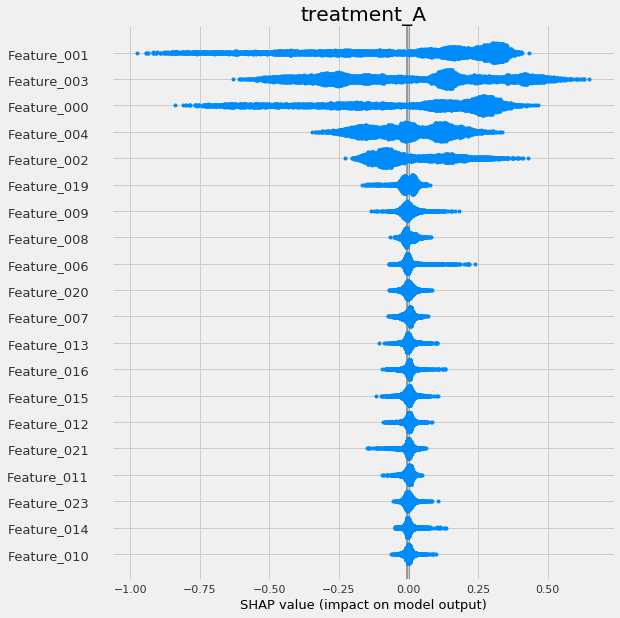

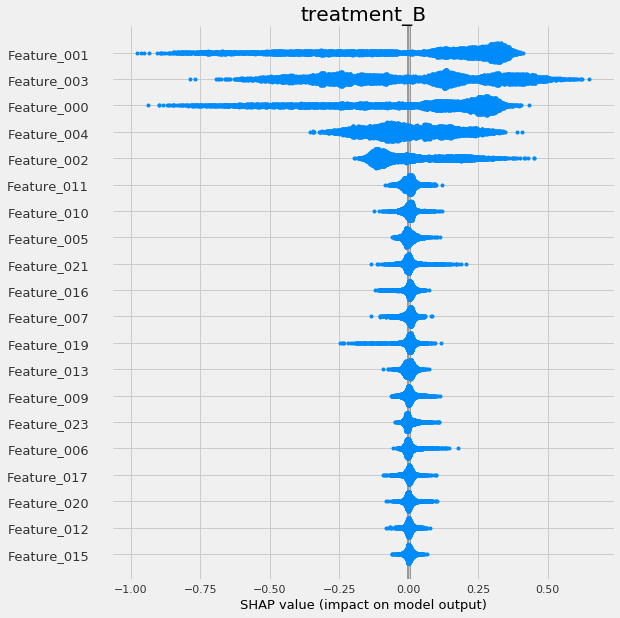

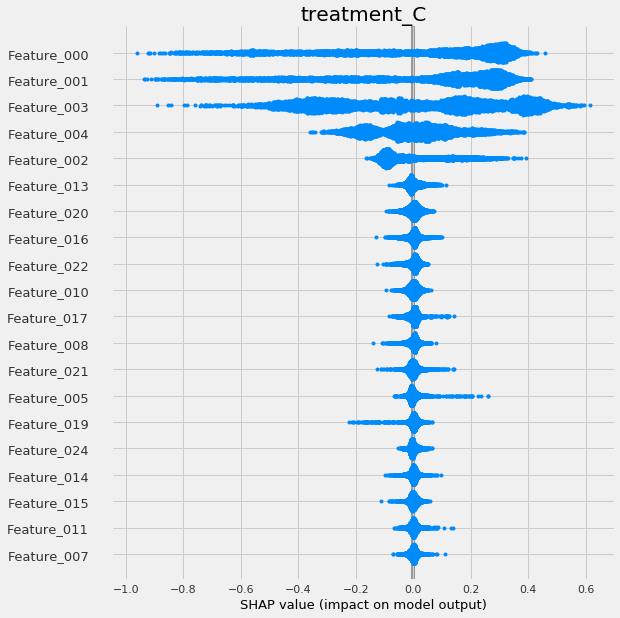

In [12]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, y=y, treatment=w_multi)

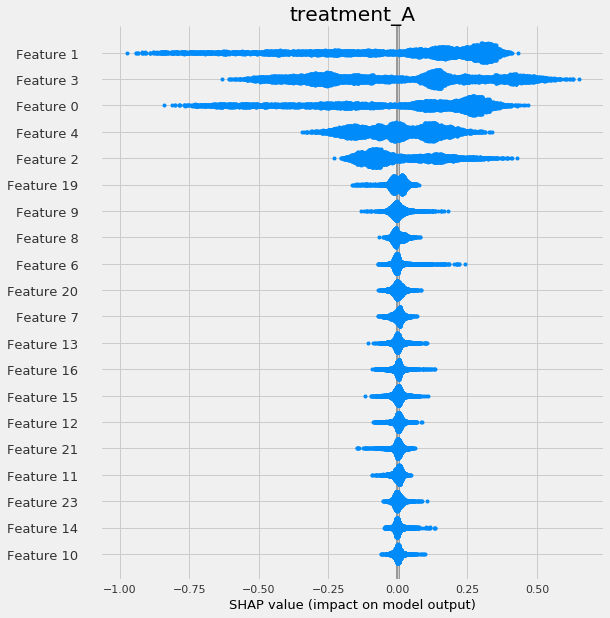

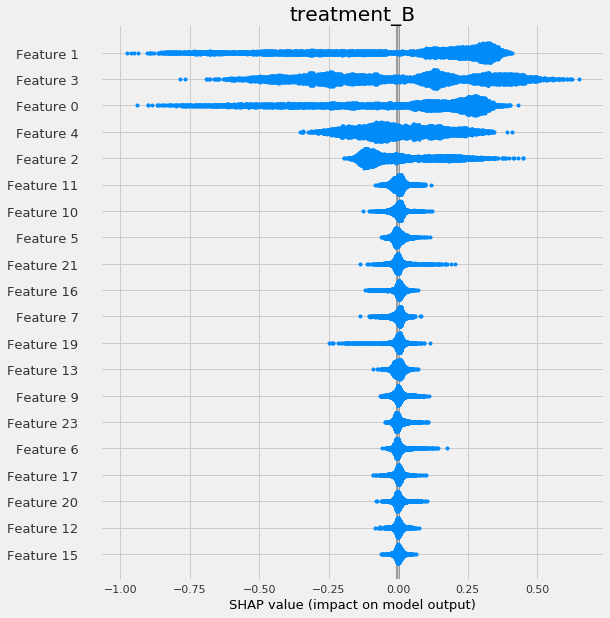

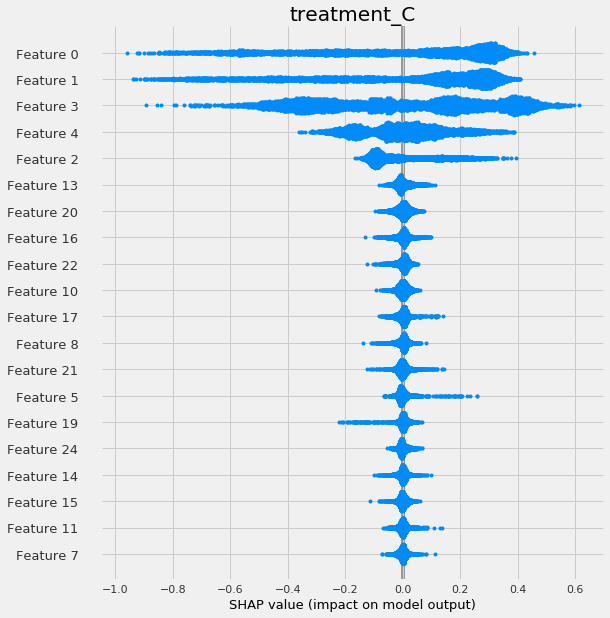

In [13]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(shap_dict=shap_slearner)

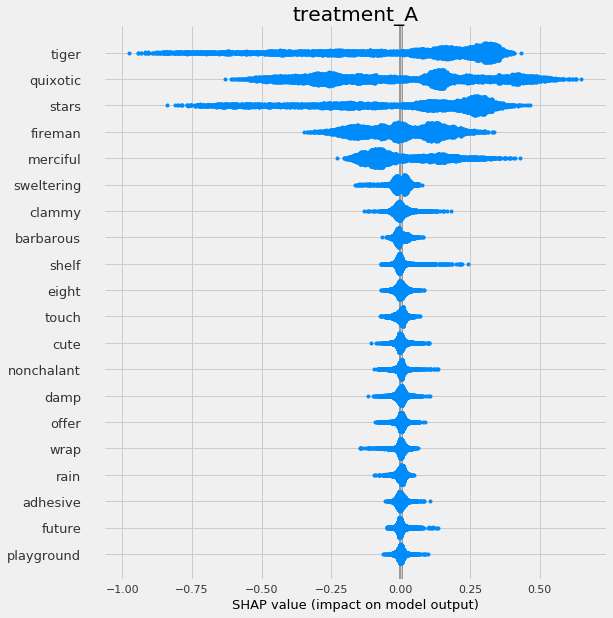

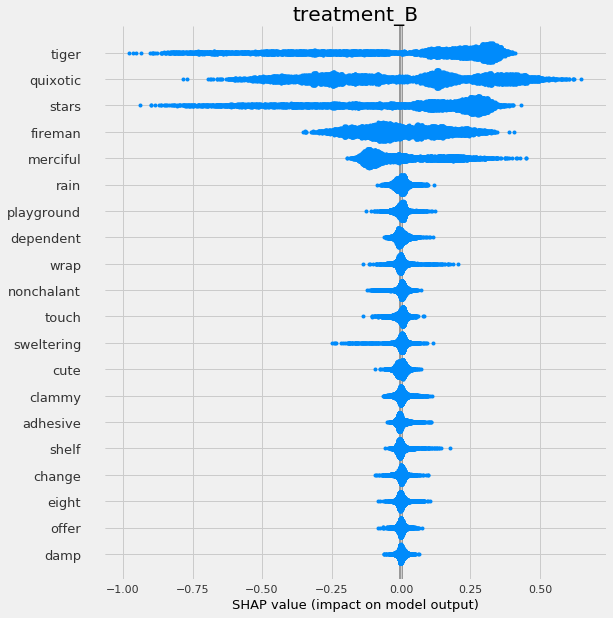

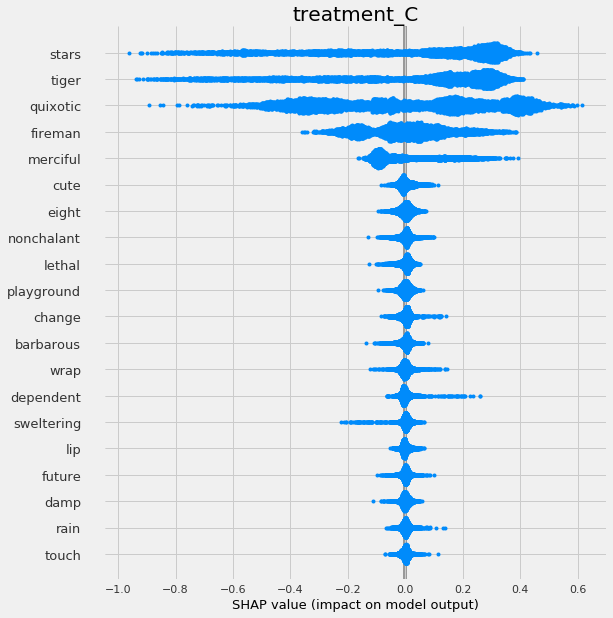

In [14]:
feature_names = ['stars', 'tiger', 'merciful', 'quixotic', 'fireman', 'dependent',
                 'shelf', 'touch', 'barbarous', 'clammy', 'playground', 'rain', 'offer',
                 'cute', 'future', 'damp', 'nonchalant', 'change', 'rigid', 'sweltering',
                 'eight', 'wrap', 'lethal', 'adhesive', 'lip']
# Plot shap values WITH specifying shap_dict AND feature name list
slearner.plot_shap_values(shap_dict=shap_slearner, features=feature_names)

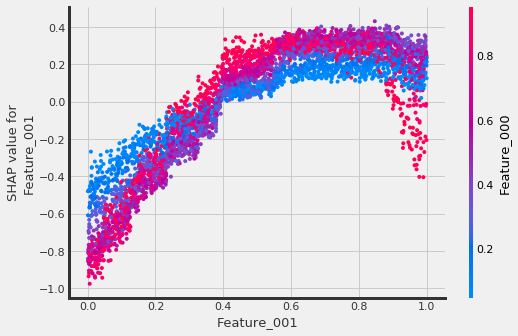

In [15]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              treatment=w_multi,
                              interaction_idx='auto',
                              shap_dict=shap_slearner)

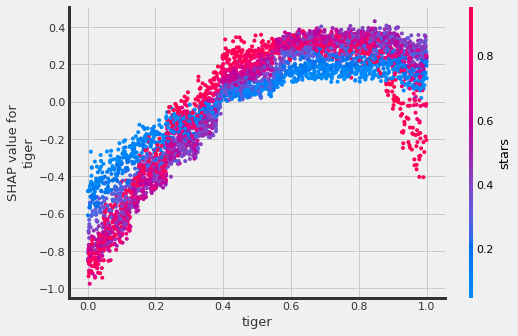

In [16]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='tiger',
                              X=X,
                              treatment=w_multi,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

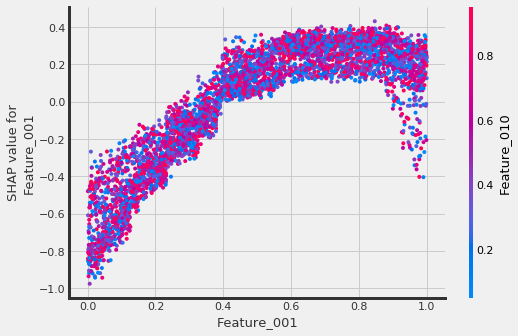

In [18]:
# interaction_idx set to specific index
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=10,
                              shap_dict=shap_slearner)

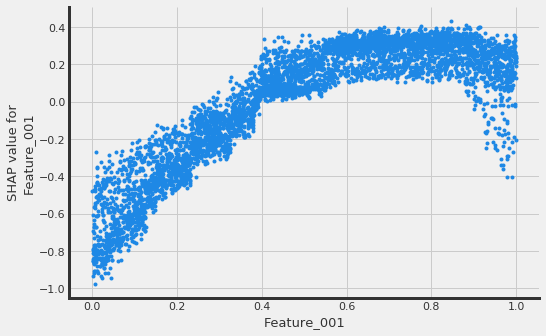

In [19]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

## T Learner

In [20]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.02992684, 0.03720439, 0.02516198]),
 array([0.01253849, 0.01978476, 0.00768306]),
 array([0.04731518, 0.05462402, 0.04264091]))

### Feature Importance (method = `gini`)

In [21]:
tlearner.get_importance(normalize=True, method='gini')

{'control_learner': {'treatment_A': Feature_000    0.075333
  Feature_001    0.072000
  Feature_002    0.071333
  Feature_004    0.056667
  Feature_003    0.055000
  Feature_020    0.040000
  Feature_022    0.038667
  Feature_012    0.038000
  Feature_006    0.037667
  Feature_015    0.037000
  Feature_021    0.035667
  Feature_024    0.035333
  Feature_011    0.035000
  Feature_010    0.034667
  Feature_016    0.034667
  Feature_013    0.033333
  Feature_017    0.033333
  Feature_005    0.032333
  Feature_023    0.031000
  Feature_014    0.030667
  Feature_019    0.030333
  Feature_007    0.029333
  Feature_008    0.029333
  Feature_009    0.026667
  Feature_018    0.026667
  dtype: float64, 'treatment_B': Feature_000    0.075333
  Feature_001    0.072000
  Feature_002    0.071333
  Feature_004    0.056667
  Feature_003    0.055000
  Feature_020    0.040000
  Feature_022    0.038667
  Feature_012    0.038000
  Feature_006    0.037667
  Feature_015    0.037000
  Feature_021    0.035667

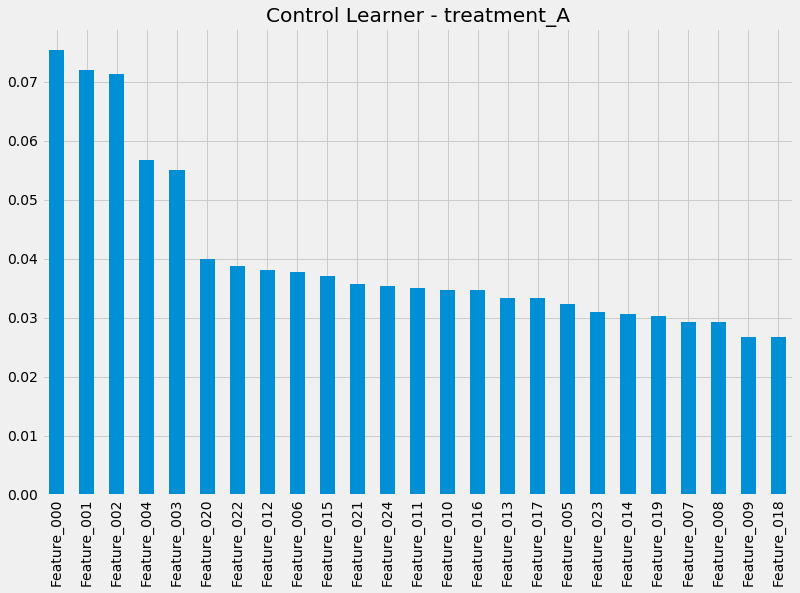

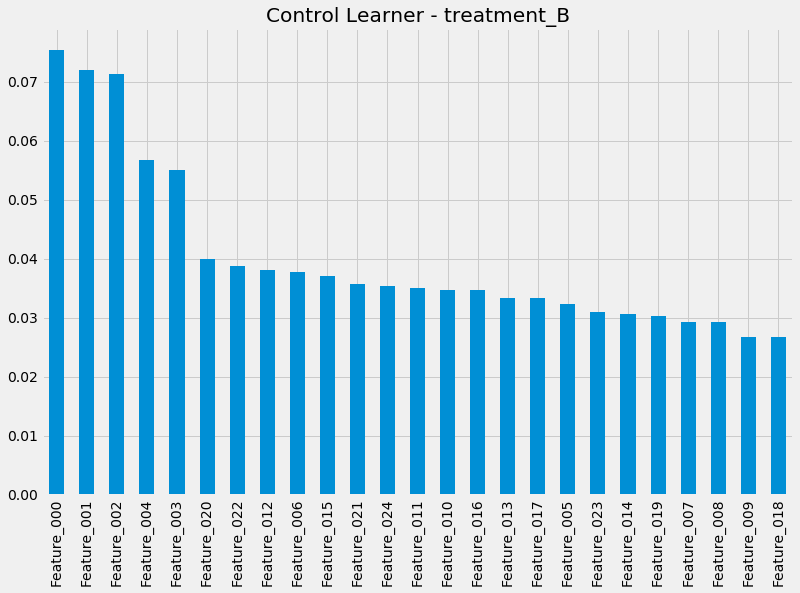

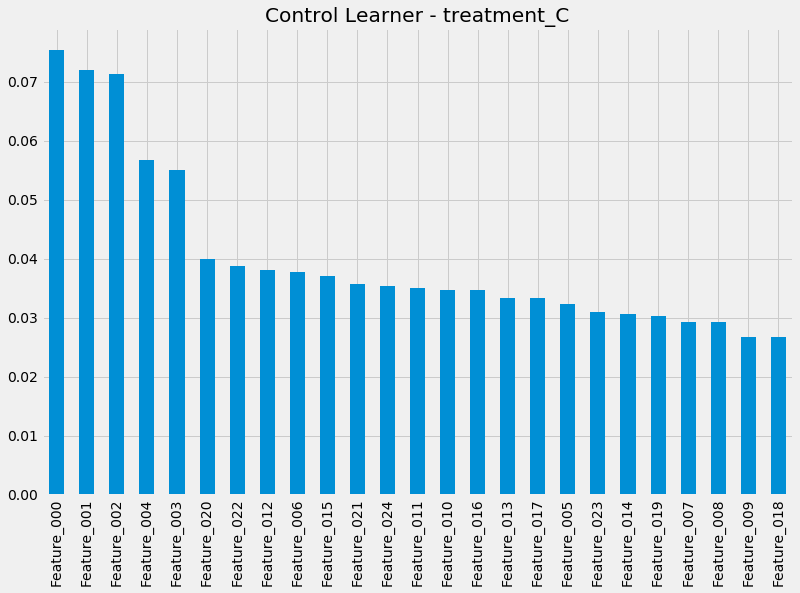

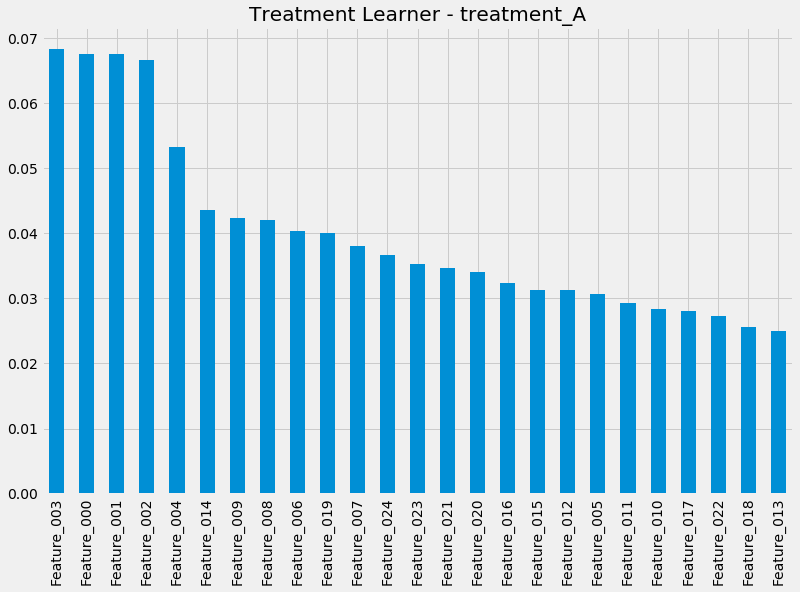

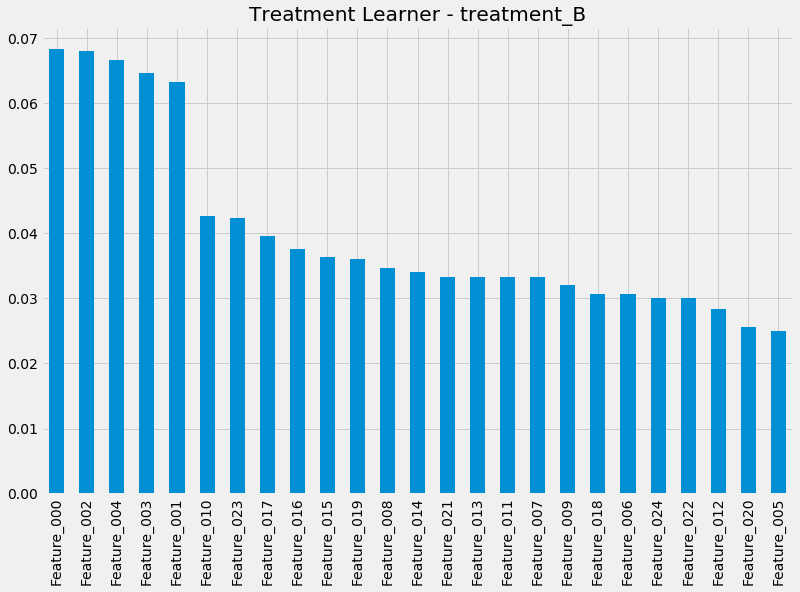

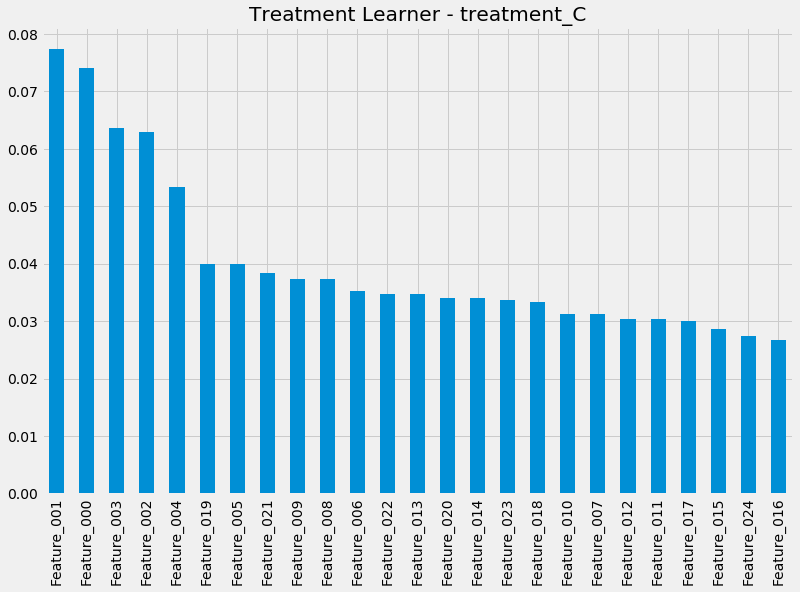

In [22]:
tlearner.plot_importance(normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [23]:
tlearner.get_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

{'control_learner': {'treatment_A': Feature_001    0.462317
  Feature_000    0.391351
  Feature_003    0.324416
  Feature_002    0.076769
  Feature_004    0.074554
  Feature_012    0.014182
  Feature_022    0.013538
  Feature_011    0.012164
  Feature_013    0.011744
  Feature_017    0.011263
  Feature_024    0.010742
  Feature_020    0.010535
  Feature_016    0.010314
  Feature_009    0.010206
  Feature_021    0.009990
  Feature_015    0.009793
  Feature_006    0.009367
  Feature_005    0.009279
  Feature_023    0.008343
  Feature_008    0.008286
  Feature_014    0.008270
  Feature_010    0.007950
  Feature_007    0.007847
  Feature_019    0.007164
  Feature_018    0.005638
  dtype: float64, 'treatment_B': Feature_001    0.461926
  Feature_000    0.372863
  Feature_003    0.319236
  Feature_004    0.079677
  Feature_002    0.073475
  Feature_022    0.014621
  Feature_012    0.013797
  Feature_011    0.013081
  Feature_017    0.012459
  Feature_013    0.012287
  Feature_016    0.011102

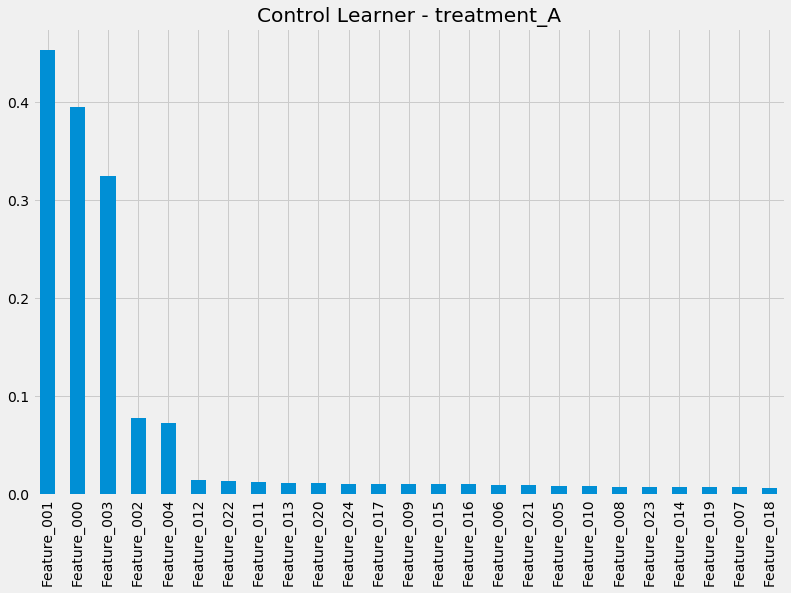

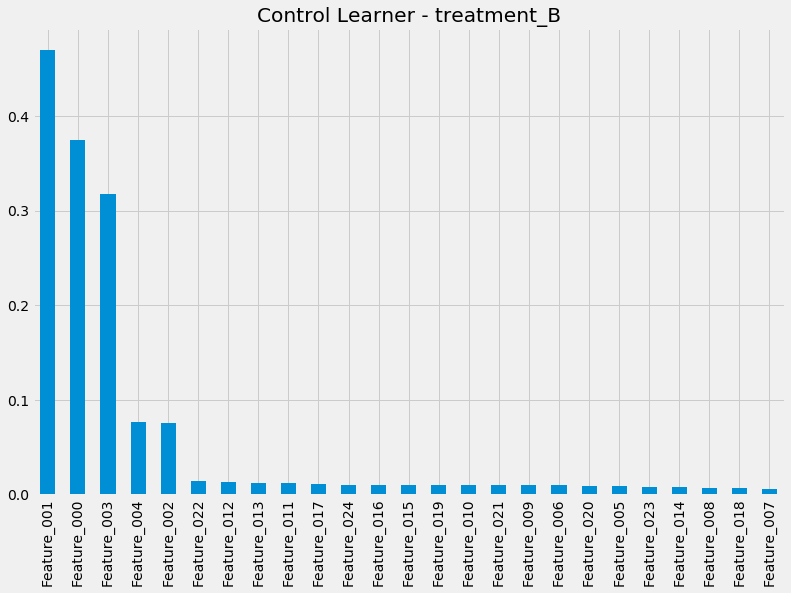

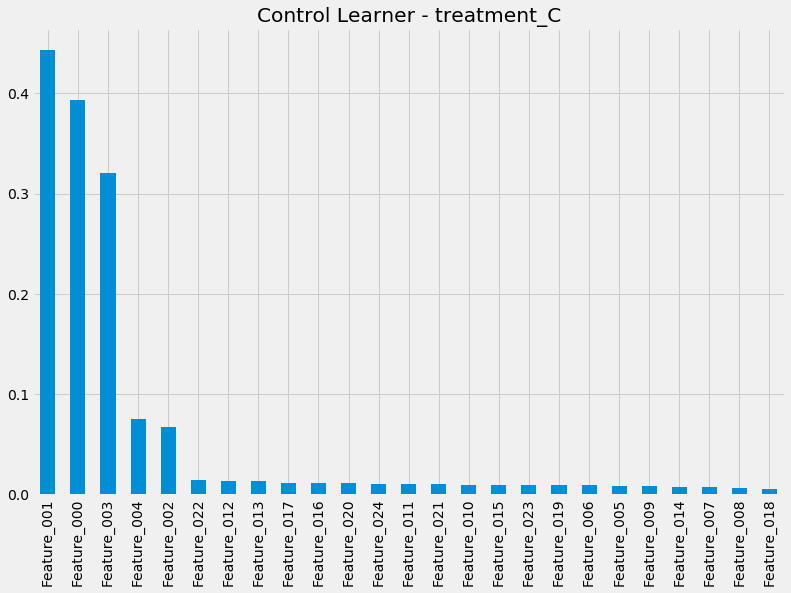

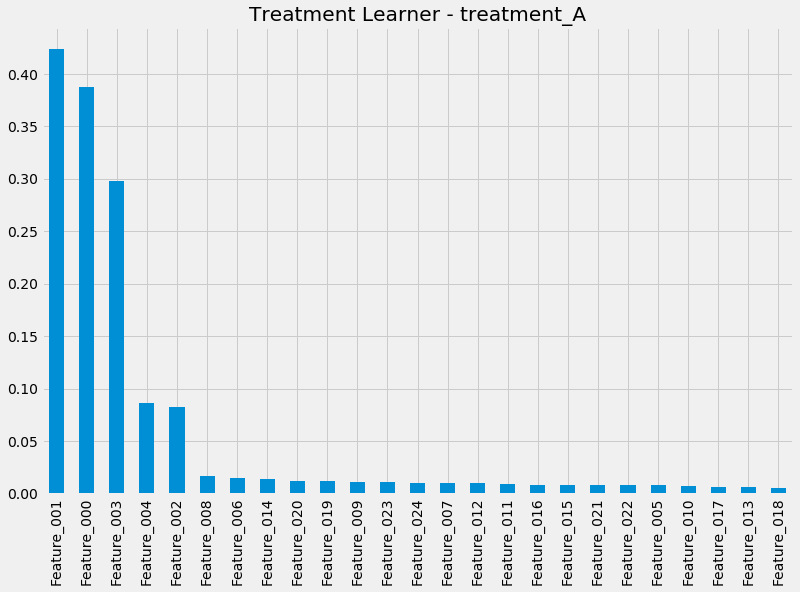

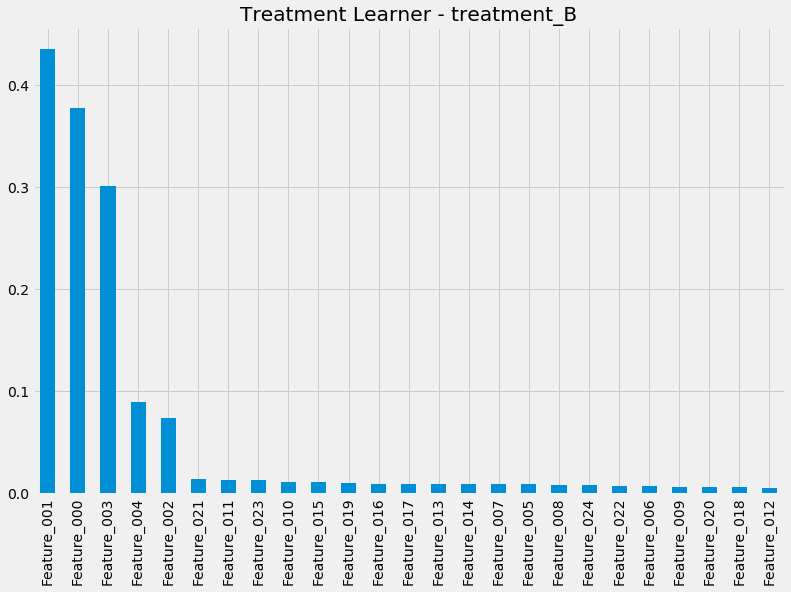

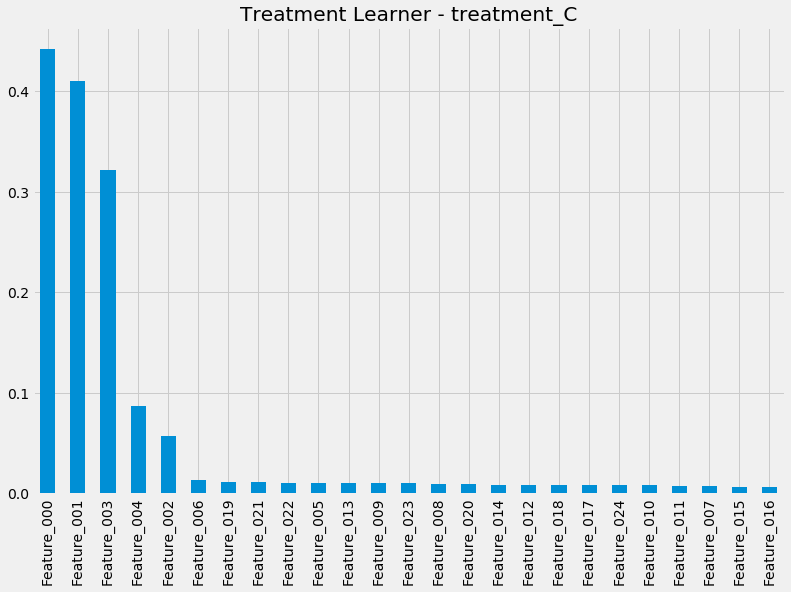

In [24]:
tlearner.plot_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

### Shapley Values

In [25]:
shap_tlearner = tlearner.get_shap_values(X=X, y=y, treatment=w_multi)
shap_tlearner

{'treatment_A': array([[ 2.56532533e-02,  1.71622128e-01,  2.18731298e-03, ...,
         -1.60800861e-02,  2.62564770e-02, -2.00637813e-03],
        [-7.87872197e-05, -1.56453457e-01, -3.70233905e-02, ...,
         -2.64095203e-02,  1.18581622e-02,  5.35860625e-03],
        [ 6.00999642e-02,  1.01177319e-01,  8.14660448e-03, ...,
          5.36309303e-03,  1.97032707e-02,  3.00863825e-02],
        ...,
        [ 1.00739286e-01,  1.58049572e-01,  9.69754326e-02, ...,
         -7.90857856e-02,  1.28275451e-02,  2.84110442e-02],
        [ 1.15061373e-01,  1.62385966e-02,  2.68481764e-02, ...,
          2.36945900e-02,  1.83006491e-02,  4.37667824e-02],
        [ 6.42966792e-02,  2.09236483e-02, -4.11477581e-02, ...,
         -2.43008111e-02, -1.98914233e-02,  8.98376867e-03]]),
 'treatment_B': array([[-0.01958953,  0.1015132 ,  0.19020841, ..., -0.00938116,
          0.0590149 , -0.05893826],
        [-0.02647516, -0.06956914, -0.05849866, ..., -0.05013525,
          0.02405239,  0.001828

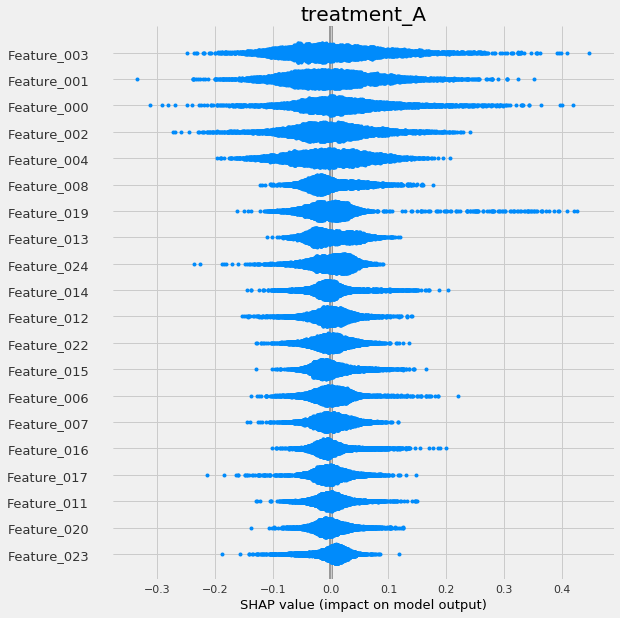

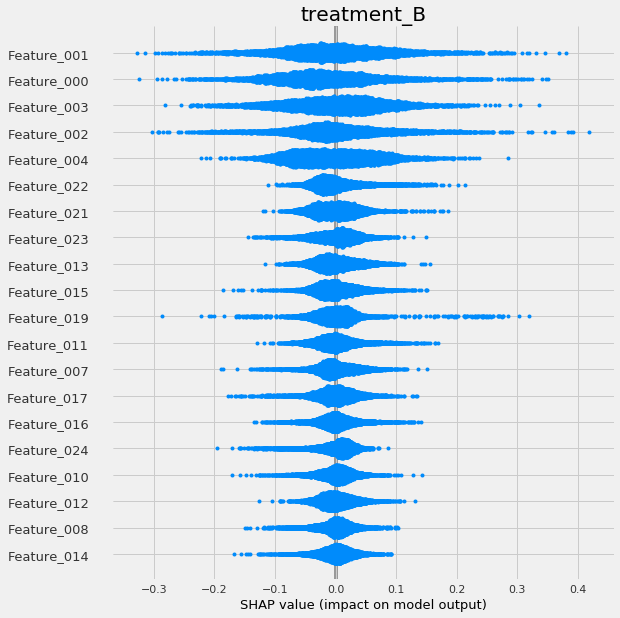

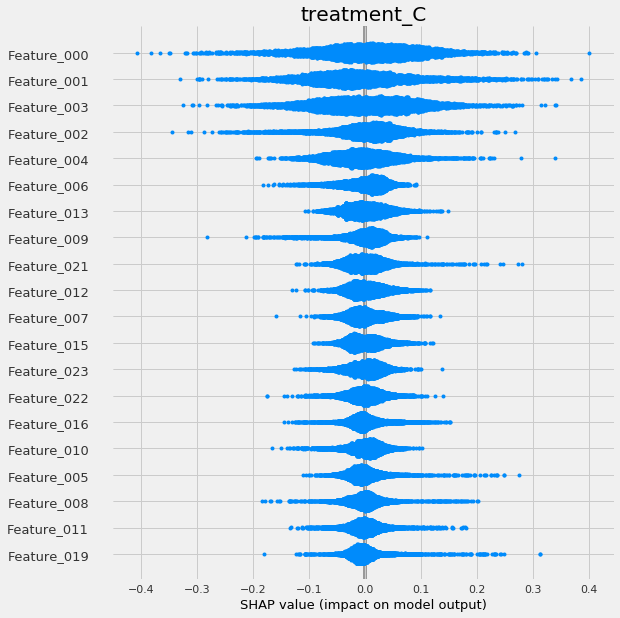

In [26]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, y=y, treatment=w_multi)

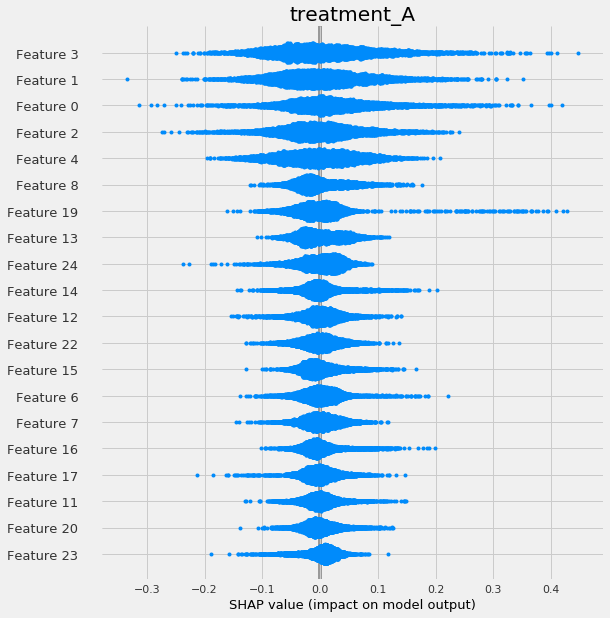

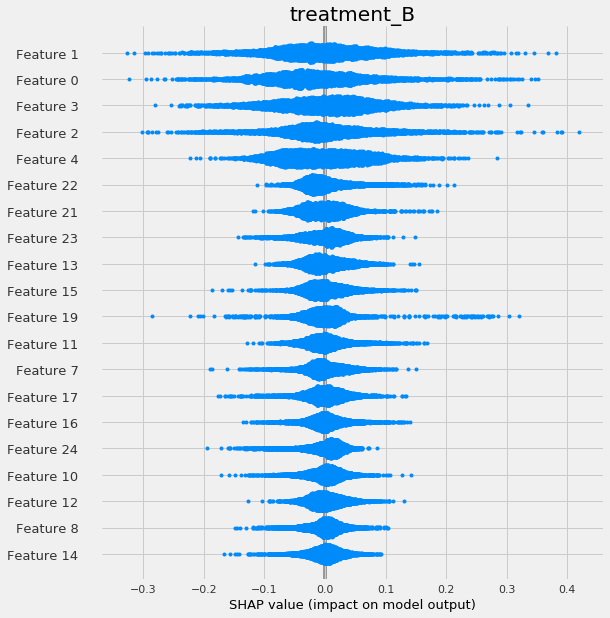

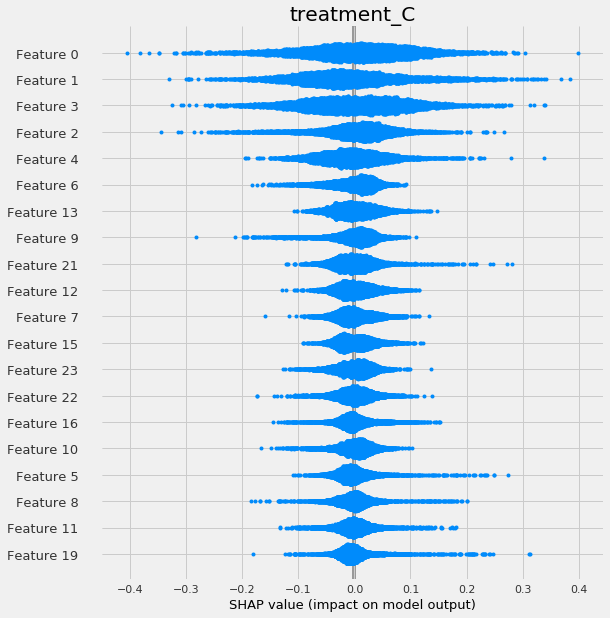

In [27]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(shap_dict=shap_tlearner)

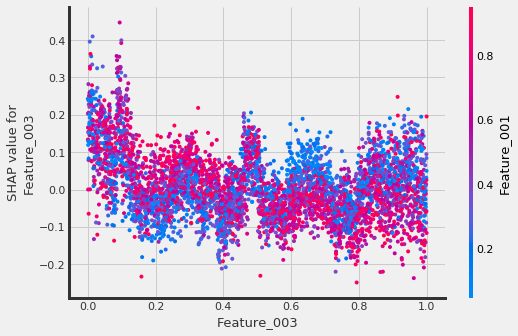

In [28]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
tlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              treatment=w_multi,
                              interaction_idx='auto',
                              shap_dict=shap_tlearner)

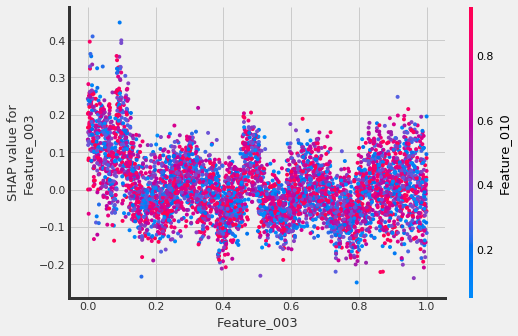

In [29]:
# interaction_idx set to specific index
tlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=10,
                              shap_dict=shap_tlearner)

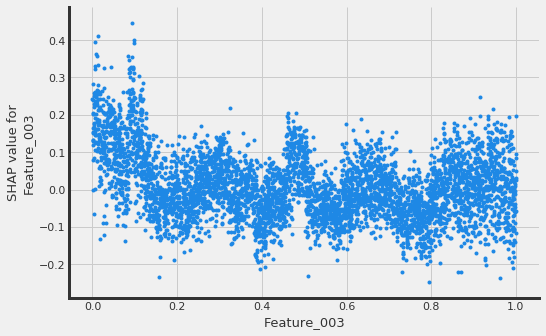

In [30]:
# interaction_idx set to None (no color coding for interaction effects)
tlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=3,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=None,
                              shap_dict=shap_tlearner)

## X Learner

In [31]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, e_multi, w_multi, y)

(array([0.01362872, 0.02211965, 0.00899699]),
 array([-0.00165222,  0.00684009, -0.00646345]),
 array([0.02890966, 0.03739922, 0.02445744]))

### Feature Importance (method = `gini`)

In [32]:
xlearner.get_importance(normalize=True, method='gini')

{'control_learner': {'treatment_A': Feature_000    0.055000
  Feature_012    0.048667
  Feature_017    0.048333
  Feature_002    0.047667
  Feature_024    0.046333
  Feature_023    0.046333
  Feature_001    0.046333
  Feature_021    0.046000
  Feature_016    0.045000
  Feature_008    0.041333
  Feature_019    0.039333
  Feature_003    0.039000
  Feature_011    0.037667
  Feature_004    0.037333
  Feature_007    0.036000
  Feature_013    0.035667
  Feature_010    0.035667
  Feature_006    0.035667
  Feature_015    0.035667
  Feature_014    0.035000
  Feature_005    0.035000
  Feature_022    0.033667
  Feature_009    0.033000
  Feature_020    0.032667
  Feature_018    0.027667
  dtype: float64, 'treatment_B': Feature_000    0.053667
  Feature_023    0.048000
  Feature_001    0.047000
  Feature_012    0.045333
  Feature_017    0.043333
  Feature_024    0.043000
  Feature_002    0.043000
  Feature_016    0.041667
  Feature_021    0.041333
  Feature_013    0.040333
  Feature_022    0.040000

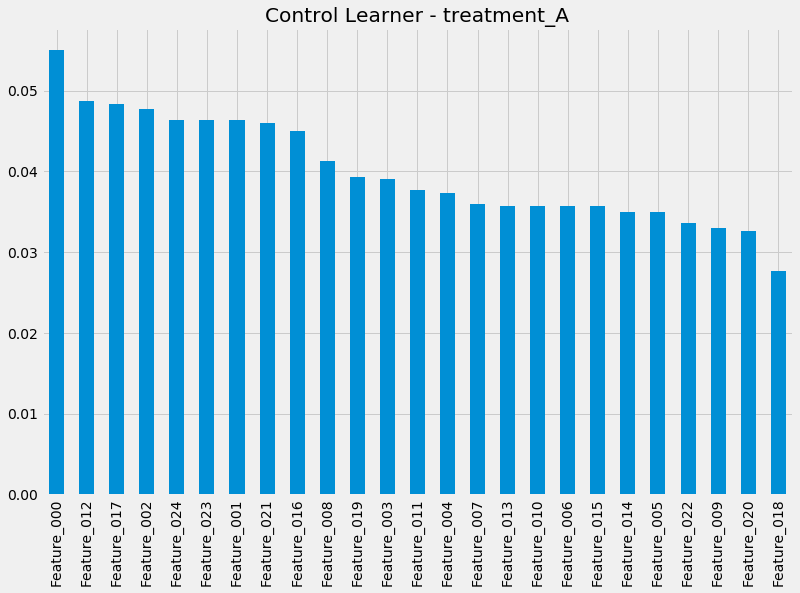

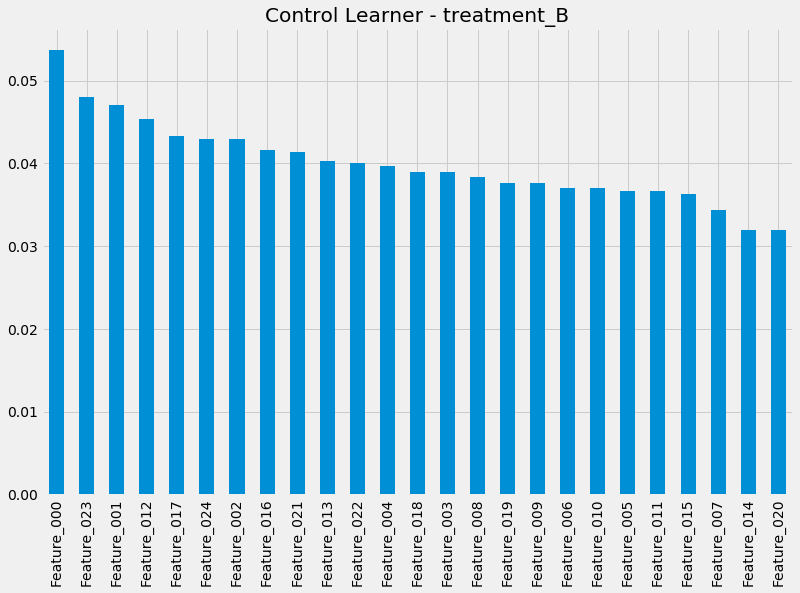

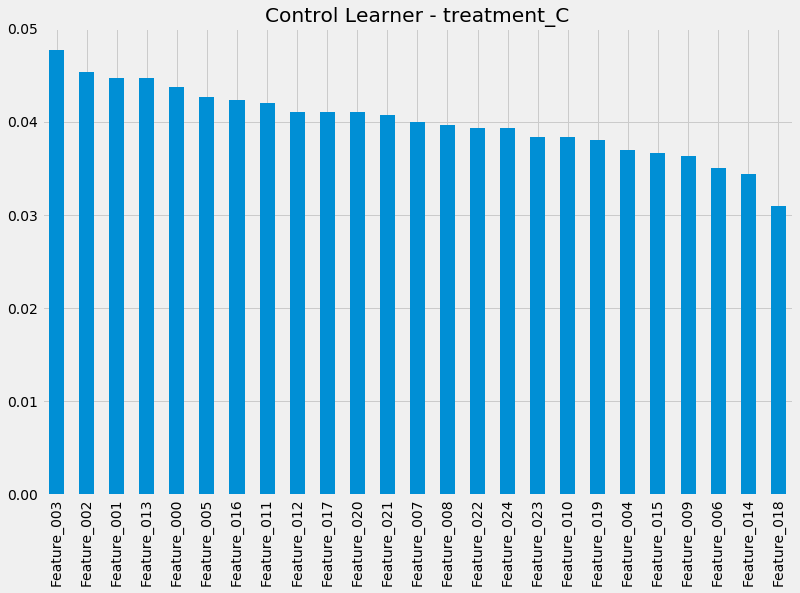

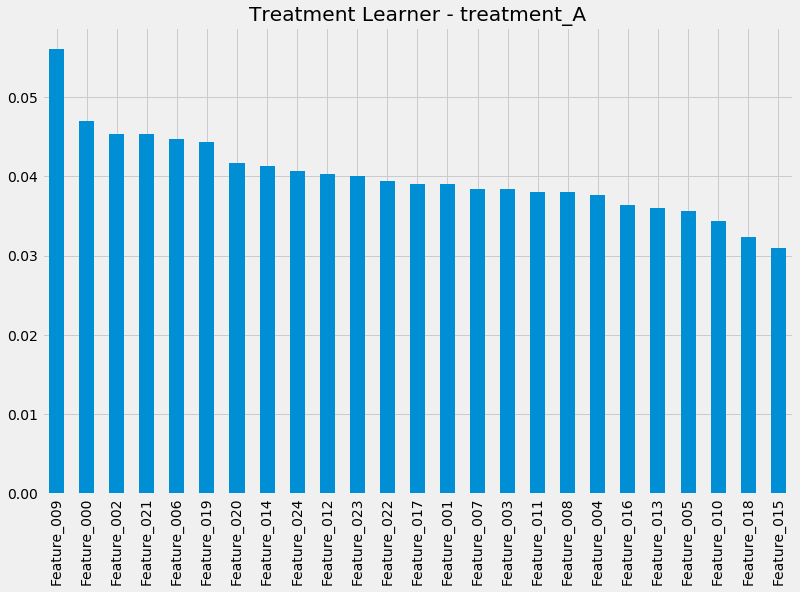

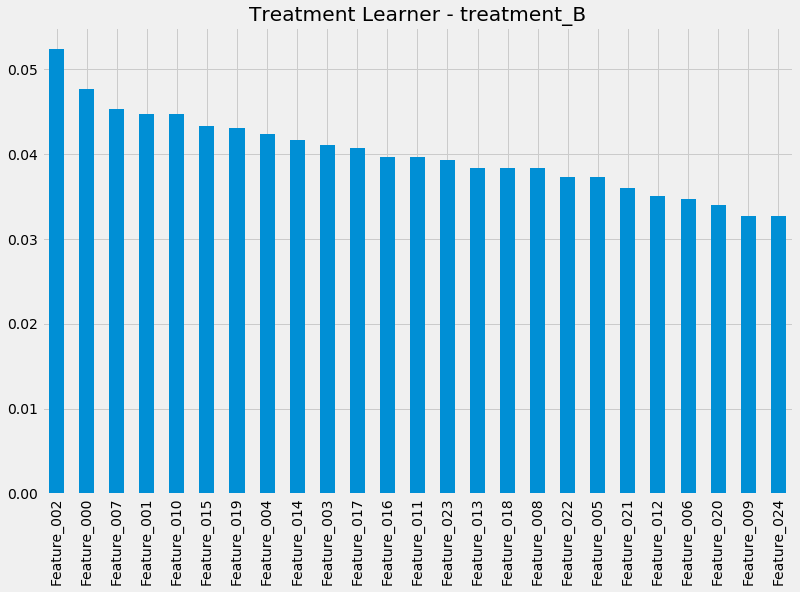

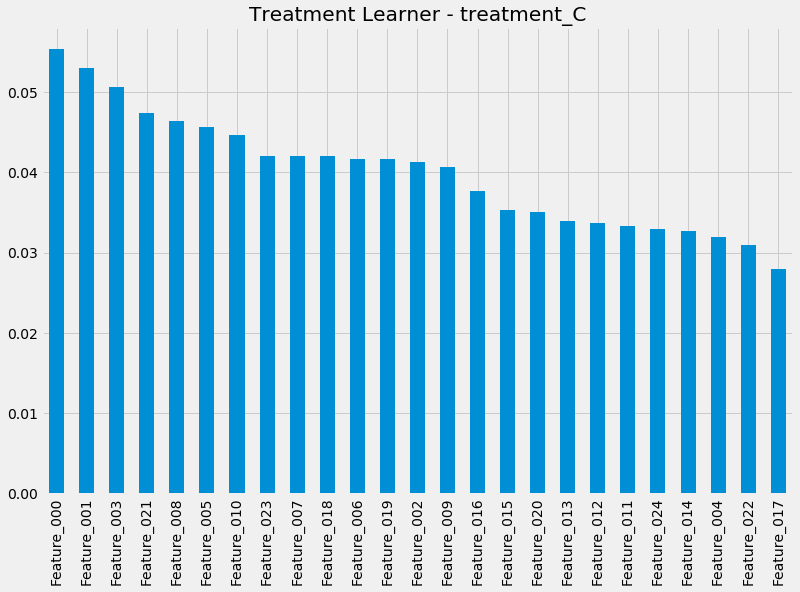

In [33]:
xlearner.plot_importance(normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [34]:
xlearner.get_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

{'control_learner': {'treatment_A': Feature_020   -0.019699
  Feature_018   -0.019913
  Feature_010   -0.022927
  Feature_005   -0.027308
  Feature_011   -0.029443
  Feature_015   -0.029469
  Feature_022   -0.029494
  Feature_009   -0.029620
  Feature_014   -0.031759
  Feature_019   -0.033200
  Feature_006   -0.034167
  Feature_008   -0.034211
  Feature_004   -0.034733
  Feature_016   -0.036688
  Feature_012   -0.040970
  Feature_024   -0.042168
  Feature_021   -0.044941
  Feature_013   -0.045491
  Feature_007   -0.045699
  Feature_017   -0.046669
  Feature_023   -0.057719
  Feature_002   -0.065822
  Feature_003   -0.081208
  Feature_001   -0.084412
  Feature_000   -0.085396
  dtype: float64, 'treatment_B': Feature_014   -0.024712
  Feature_020   -0.024993
  Feature_006   -0.027326
  Feature_015   -0.028931
  Feature_005   -0.029469
  Feature_021   -0.030198
  Feature_004   -0.030660
  Feature_008   -0.030852
  Feature_024   -0.031313
  Feature_017   -0.032088
  Feature_010   -0.033112

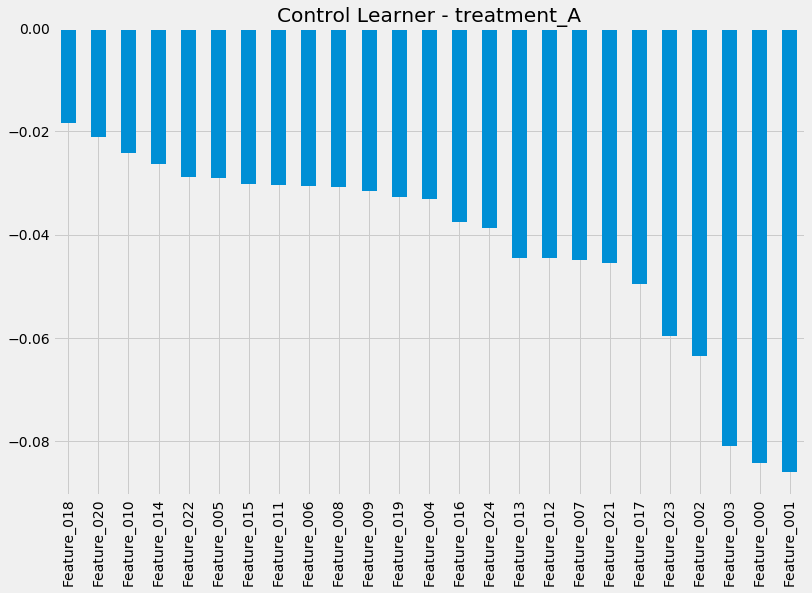

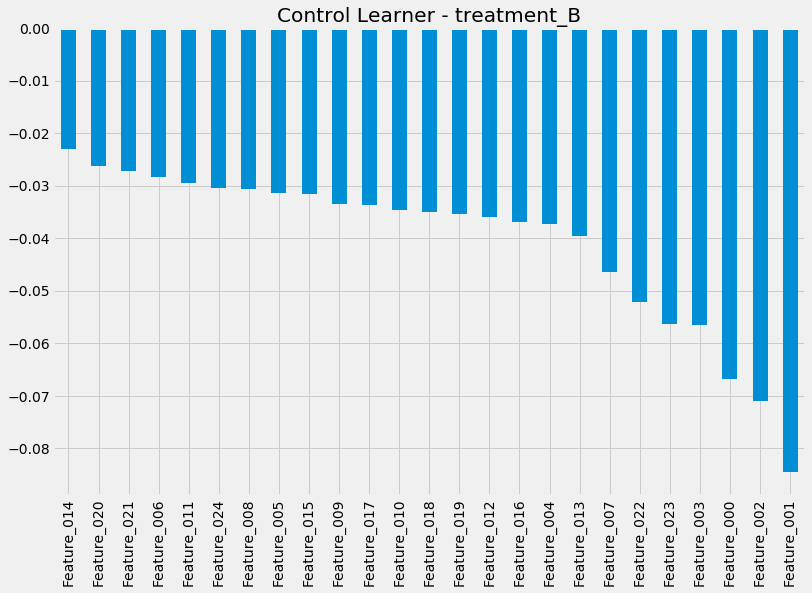

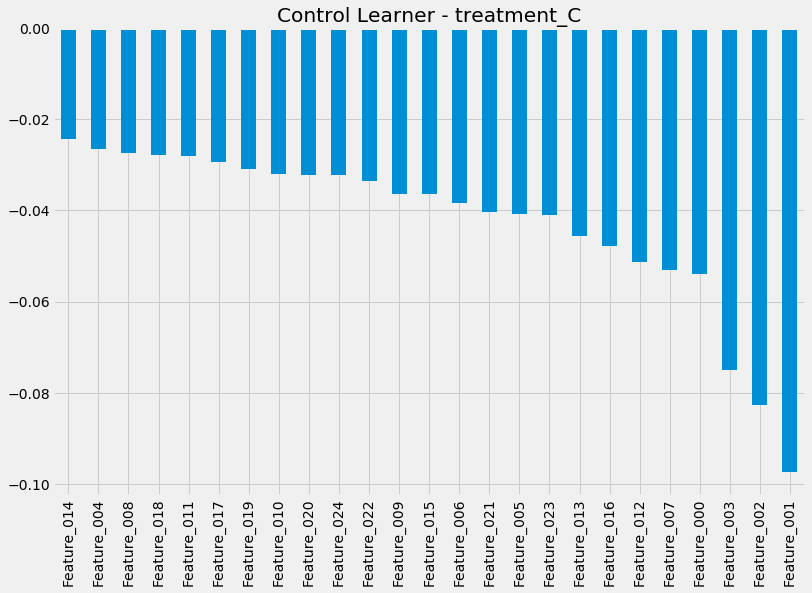

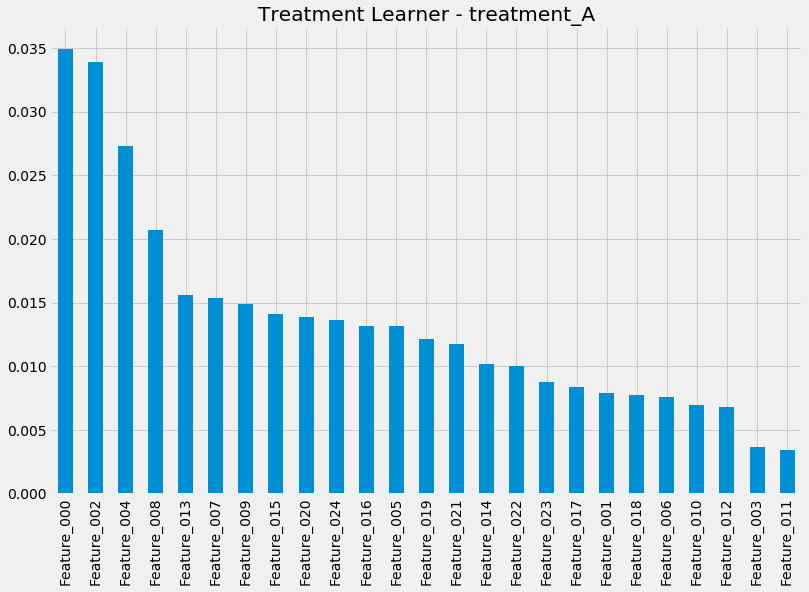

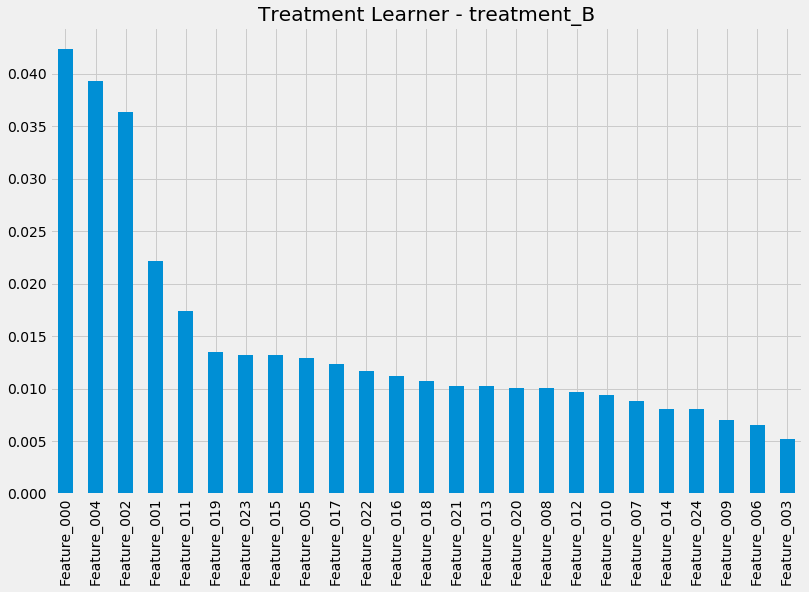

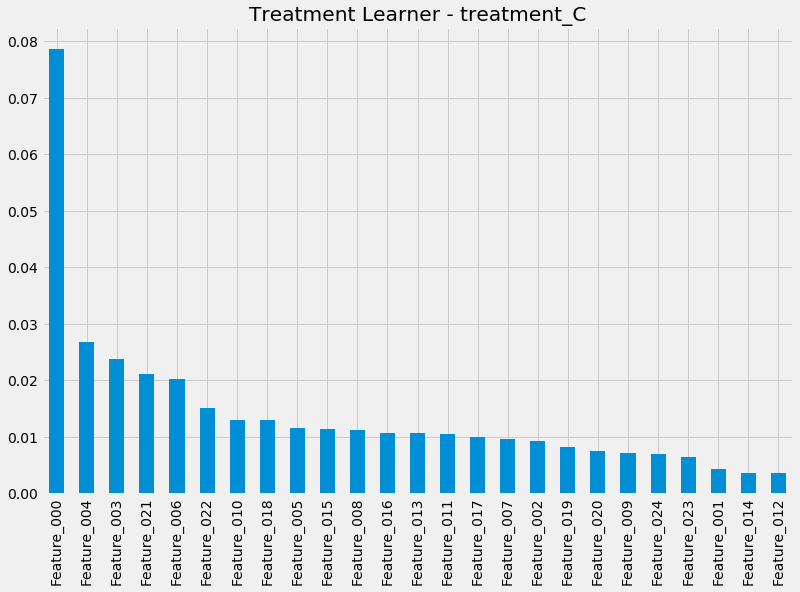

In [35]:
xlearner.plot_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

### Shapley Values

In [36]:
shap_xlearner = xlearner.get_shap_values(X=X, y=y, treatment=w_multi, p=e_multi)
shap_xlearner

{'treatment_A': array([[-0.01870038,  0.03214804, -0.05229813, ..., -0.02209687,
          0.0294695 , -0.02563787],
        [-0.01115592, -0.07213313, -0.00373563, ..., -0.01905188,
          0.00665278,  0.00124972],
        [-0.01482793,  0.0615812 ,  0.0028895 , ...,  0.00660739,
          0.01755494,  0.03420602],
        ...,
        [ 0.06493816,  0.02692392,  0.01920401, ..., -0.02173353,
          0.00520821,  0.02375755],
        [ 0.01690844, -0.02065631,  0.01565087, ...,  0.02351777,
         -0.00773449,  0.01920257],
        [ 0.0090525 ,  0.00541117, -0.01555445, ..., -0.00532886,
         -0.00780857,  0.00950019]]),
 'treatment_B': array([[-0.01754517,  0.05811038,  0.12651385, ..., -0.00617359,
          0.03580755, -0.0320595 ],
        [-0.03372649, -0.06097964, -0.03200801, ..., -0.03817602,
         -0.00134721,  0.00118601],
        [-0.03030632,  0.01249964, -0.0394033 , ...,  0.00737746,
          0.04882042,  0.02441089],
        ...,
        [-0.02026812, -0

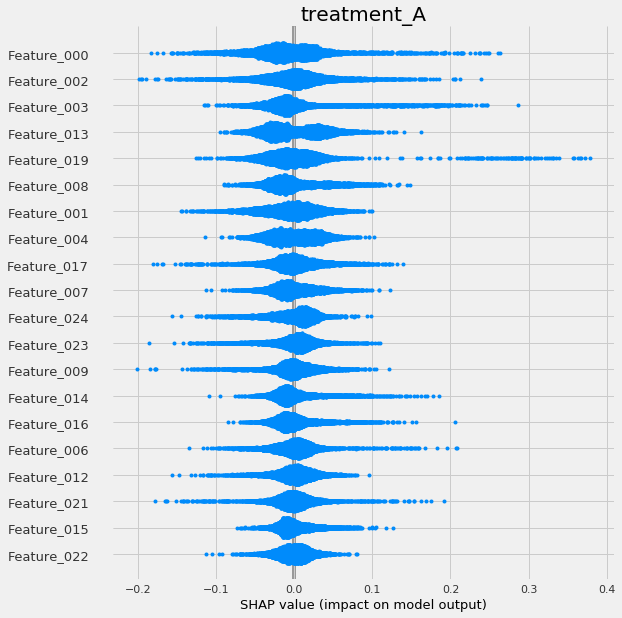

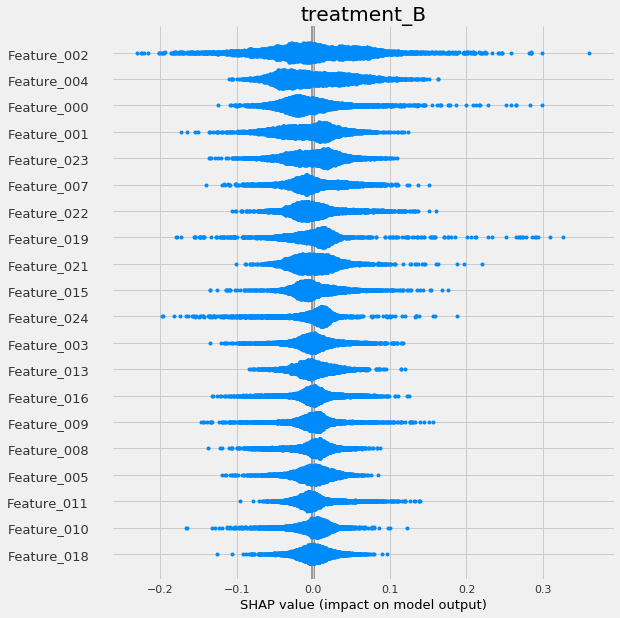

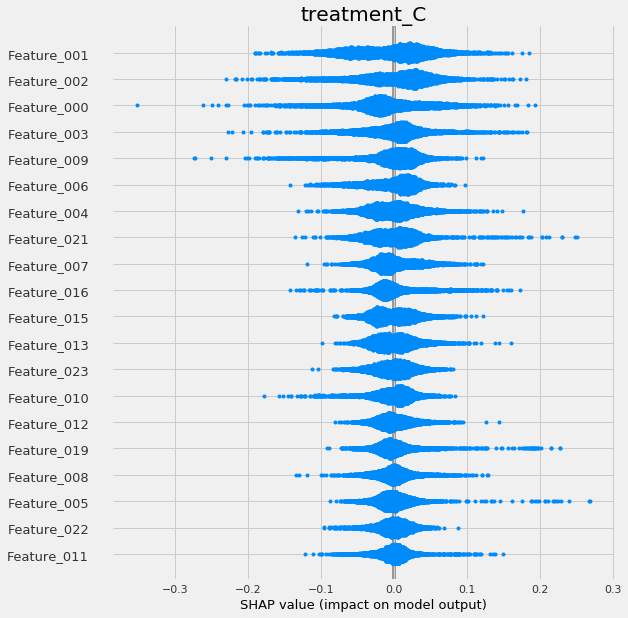

In [37]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, y=y, treatment=w_multi, p=e_multi)

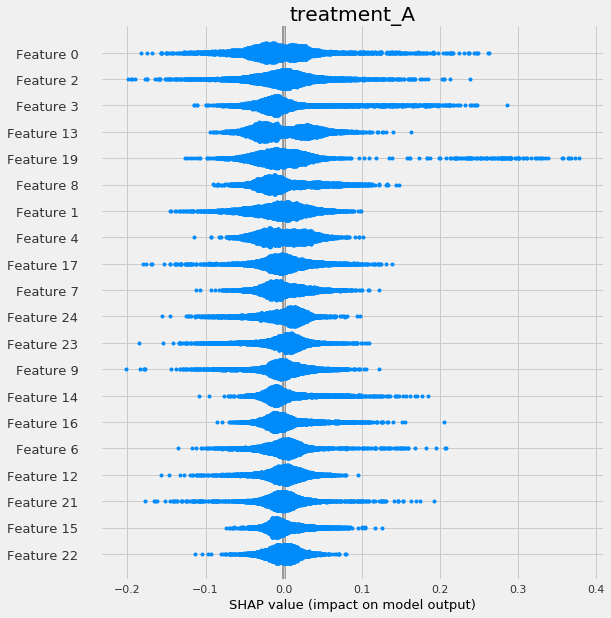

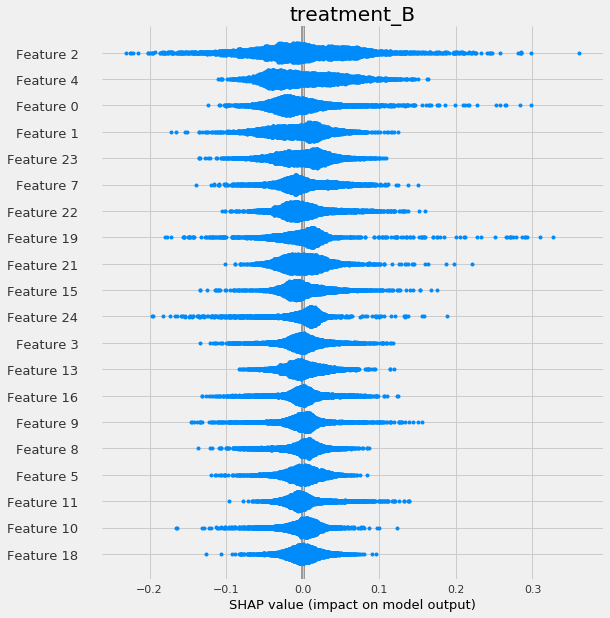

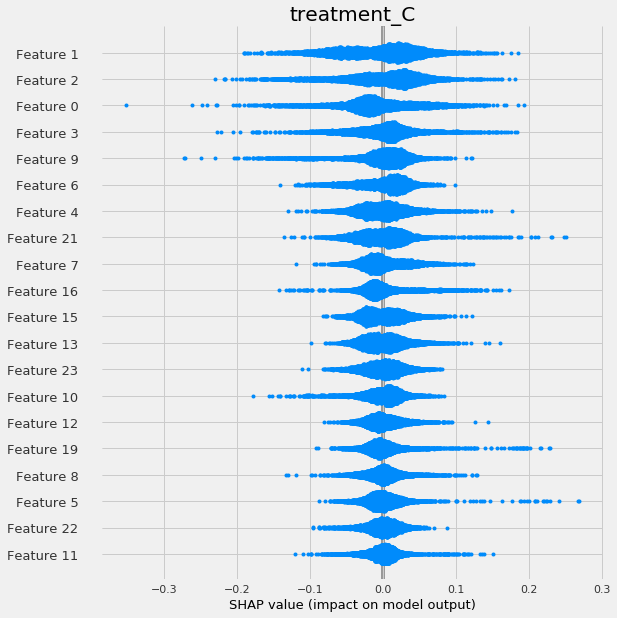

In [38]:
# shap_dict specified
xlearner.plot_shap_values(shap_dict=shap_xlearner)

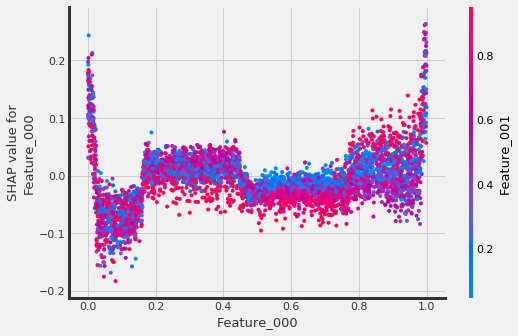

In [39]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              treatment=w_multi,
                              interaction_idx='auto',
                              shap_dict=shap_xlearner)

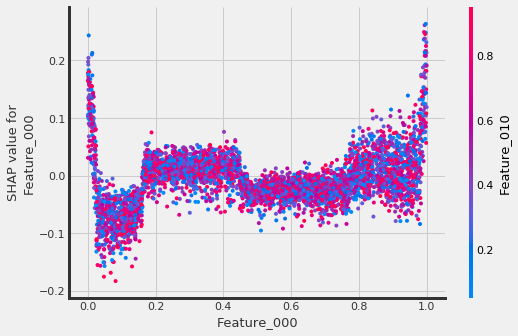

In [40]:
# interaction_idx set to specific index
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=10,
                              shap_dict=shap_xlearner)

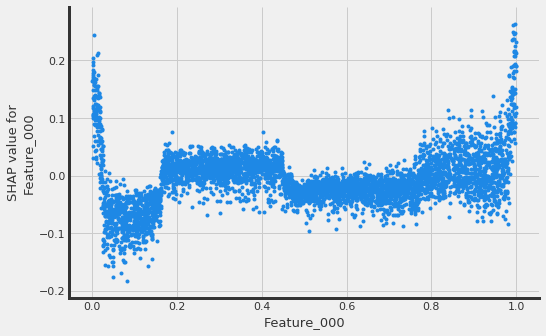

In [41]:
# interaction_idx set to None (no color coding for interaction effects)
xlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=0,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=None,
                              shap_dict=shap_xlearner)

## R Learner

In [42]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner.estimate_ate(X, e_multi, w_multi, y)

(array([0.00971913, 0.00971345, 0.01023806]),
 array([0.00946287, 0.00945811, 0.00998082]),
 array([0.00997539, 0.00996879, 0.0104953 ]))

### Feature Importance (method = `gini`)

In [43]:
rlearner.get_importance(normalize=True, method='gini')

{'treatment_A': Feature_017    0.052000
 Feature_002    0.044667
 Feature_012    0.043333
 Feature_006    0.043333
 Feature_019    0.043333
 Feature_003    0.042667
 Feature_024    0.042000
 Feature_000    0.041333
 Feature_008    0.041000
 Feature_023    0.040333
 Feature_005    0.040000
 Feature_010    0.039000
 Feature_016    0.039000
 Feature_014    0.038667
 Feature_013    0.038667
 Feature_007    0.038667
 Feature_021    0.038333
 Feature_018    0.038333
 Feature_022    0.037333
 Feature_009    0.037000
 Feature_001    0.037000
 Feature_015    0.036333
 Feature_011    0.036000
 Feature_020    0.036000
 Feature_004    0.035667
 dtype: float64, 'treatment_B': Feature_008    0.050000
 Feature_002    0.049000
 Feature_020    0.045000
 Feature_001    0.044667
 Feature_000    0.043000
 Feature_011    0.043000
 Feature_024    0.042000
 Feature_023    0.041667
 Feature_016    0.041333
 Feature_015    0.041333
 Feature_004    0.041000
 Feature_007    0.041000
 Feature_005    0.040667
 Fea

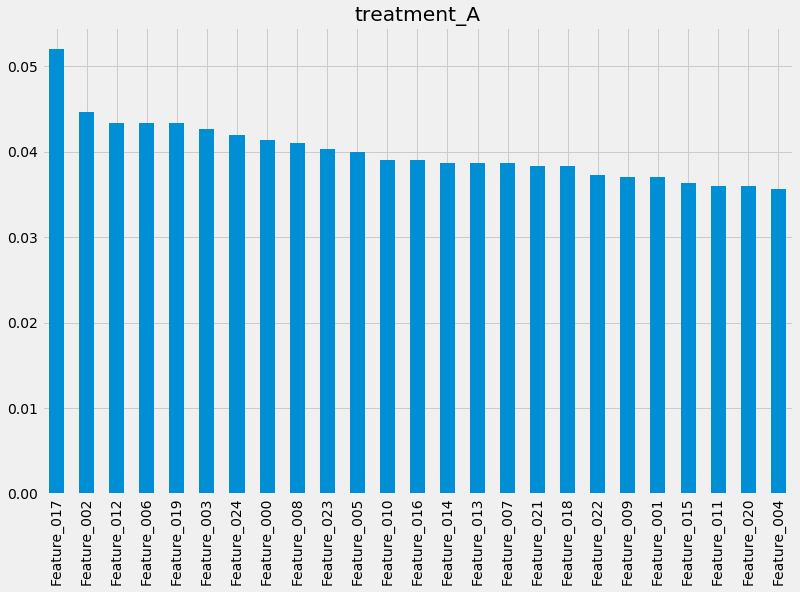

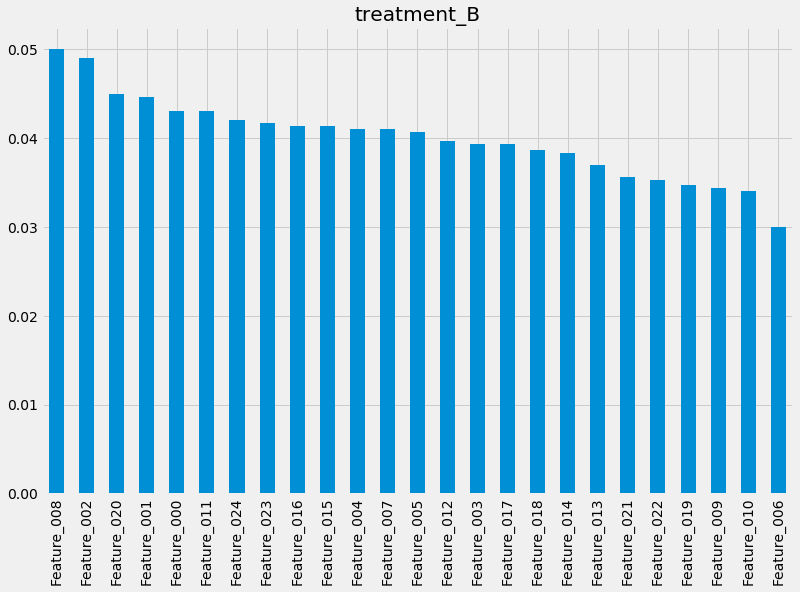

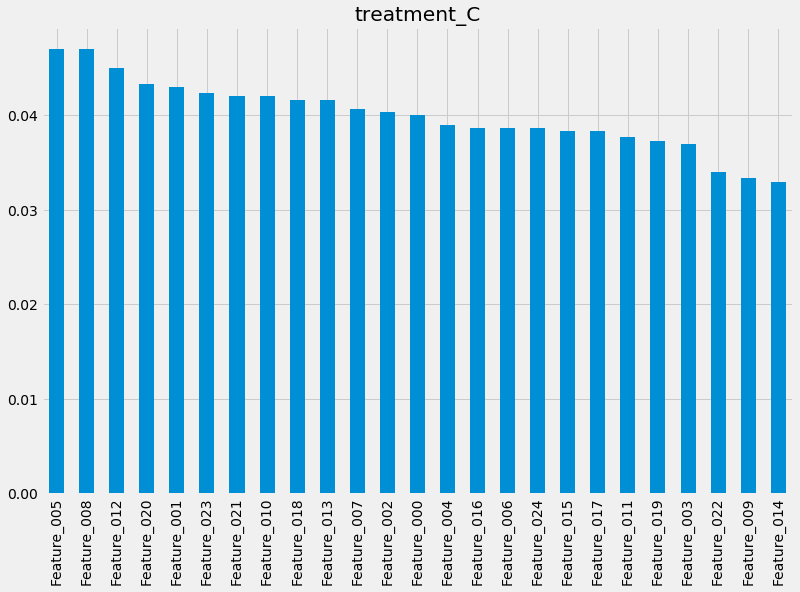

In [44]:
rlearner.plot_importance(normalize=True, method='gini')

### Feature Importance (method = `permutation`)

In [45]:
rlearner.get_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

{'treatment_A': Feature_022   -0.011016
 Feature_011   -0.012167
 Feature_010   -0.013748
 Feature_021   -0.019500
 Feature_002   -0.020073
 Feature_004   -0.020742
 Feature_024   -0.021960
 Feature_020   -0.022817
 Feature_018   -0.022902
 Feature_008   -0.023395
 Feature_016   -0.024426
 Feature_015   -0.025257
 Feature_023   -0.026336
 Feature_012   -0.026577
 Feature_013   -0.027188
 Feature_000   -0.027389
 Feature_009   -0.028310
 Feature_019   -0.029418
 Feature_007   -0.029599
 Feature_006   -0.030075
 Feature_005   -0.031627
 Feature_014   -0.037767
 Feature_003   -0.037824
 Feature_017   -0.045904
 Feature_001   -0.048954
 dtype: float64, 'treatment_B': Feature_006   -0.015024
 Feature_019   -0.015280
 Feature_004   -0.017396
 Feature_010   -0.018049
 Feature_012   -0.021041
 Feature_024   -0.021617
 Feature_021   -0.021739
 Feature_014   -0.021835
 Feature_009   -0.024141
 Feature_020   -0.024368
 Feature_016   -0.024769
 Feature_018   -0.024970
 Feature_017   -0.026631
 Fea

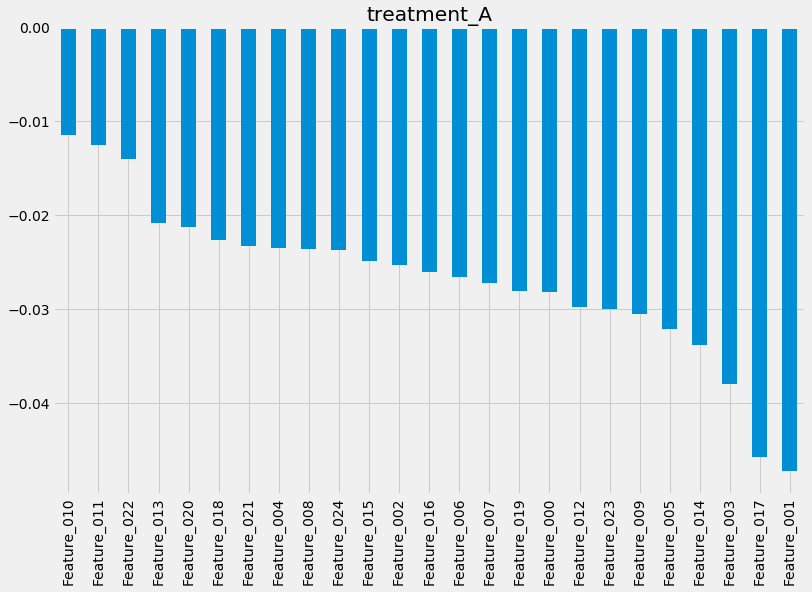

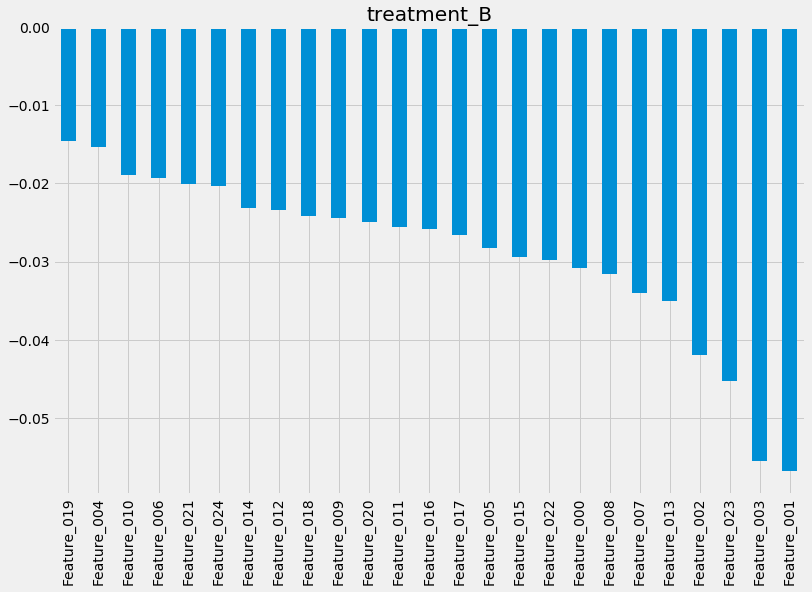

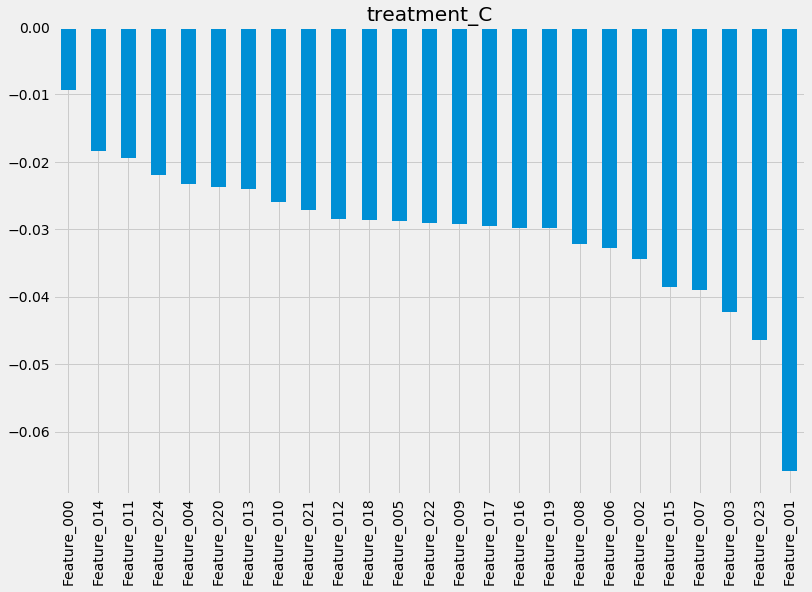

In [46]:
rlearner.plot_importance(X=X, y=y, treatment=w_multi, normalize=True, method='permutation')

### Shapley Values

In [47]:
shap_rlearner = rlearner.get_shap_values(X=X, y=y, treatment=w_multi)
shap_rlearner

{'treatment_A': array([[-0.02037821,  0.02961336, -0.01057978, ...,  0.02688562,
          0.03760385, -0.01535562],
        [-0.00019709, -0.03622671, -0.04434764, ..., -0.01487355,
          0.00750935,  0.00844517],
        [ 0.00875053,  0.04252905, -0.02554941, ...,  0.01330121,
         -0.00058777,  0.01065917],
        ...,
        [ 0.01088696,  0.00970124,  0.04547651, ...,  0.00835953,
          0.00175061,  0.00696424],
        [ 0.01905461, -0.00437841, -0.01044121, ...,  0.00446578,
         -0.00300476,  0.01233608],
        [-0.00425485,  0.02427034, -0.06708917, ...,  0.01159743,
          0.00656799,  0.00193518]]),
 'treatment_B': array([[ 0.00272259,  0.0430356 ,  0.09504613, ..., -0.03232616,
          0.06138772, -0.11757542],
        [-0.01230836, -0.0535224 , -0.07223094, ..., -0.02674657,
          0.00317456,  0.00937986],
        [ 0.00753247, -0.0082344 , -0.0311851 , ...,  0.01962986,
          0.03261733,  0.01430038],
        ...,
        [-0.01545483, -0

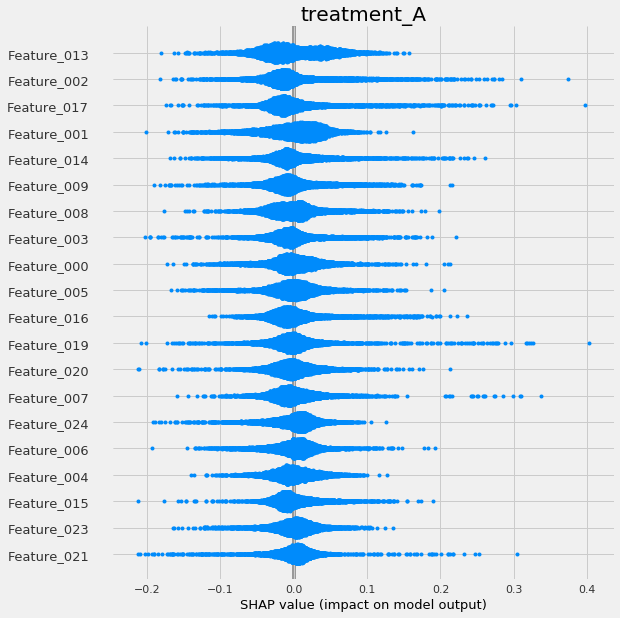

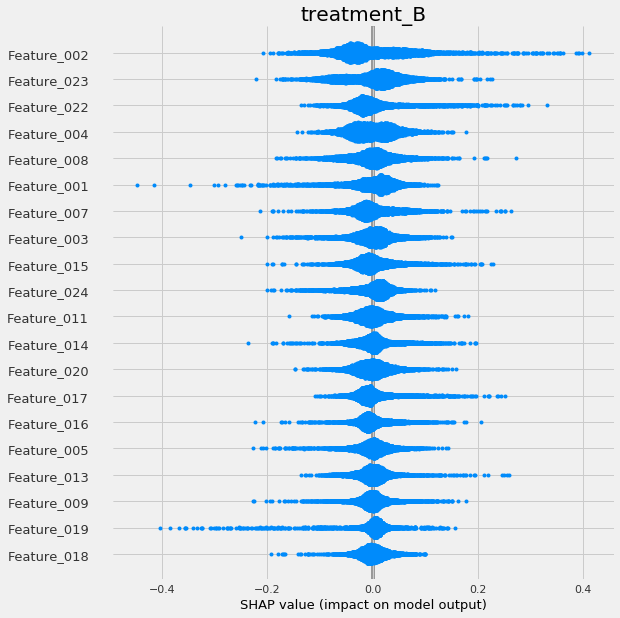

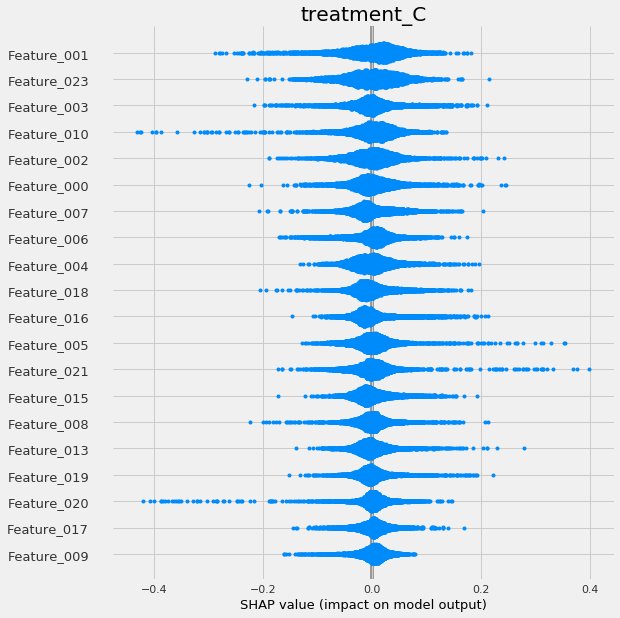

In [48]:
# without providing shap_dict
rlearner.plot_shap_values(X=X, y=y, treatment=w_multi)

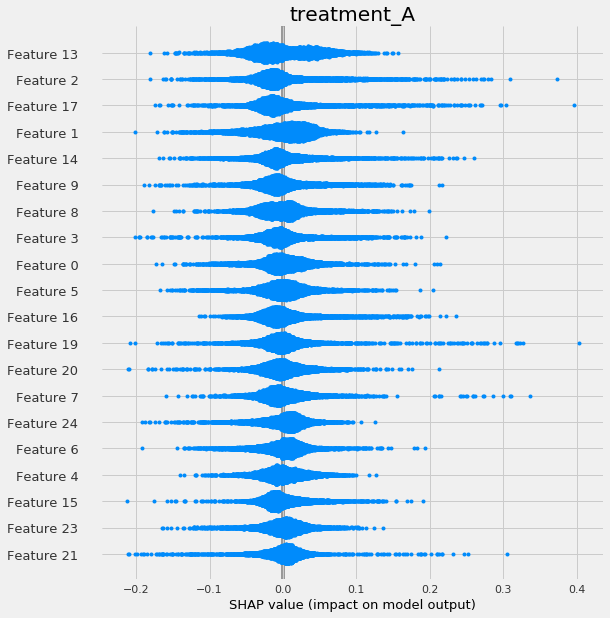

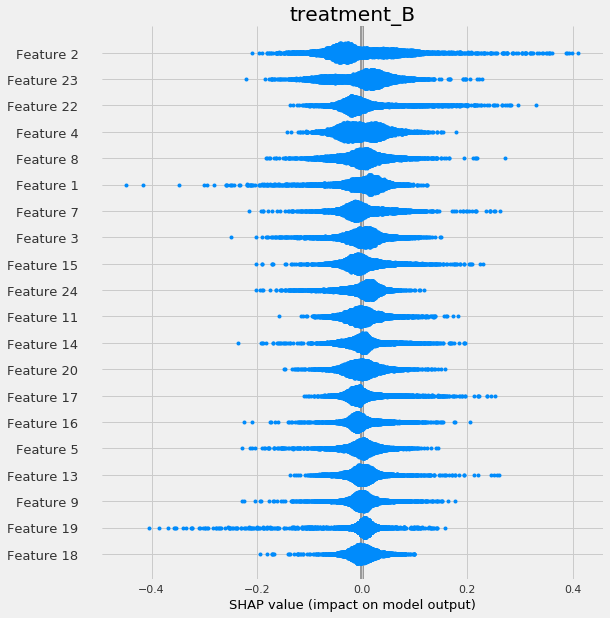

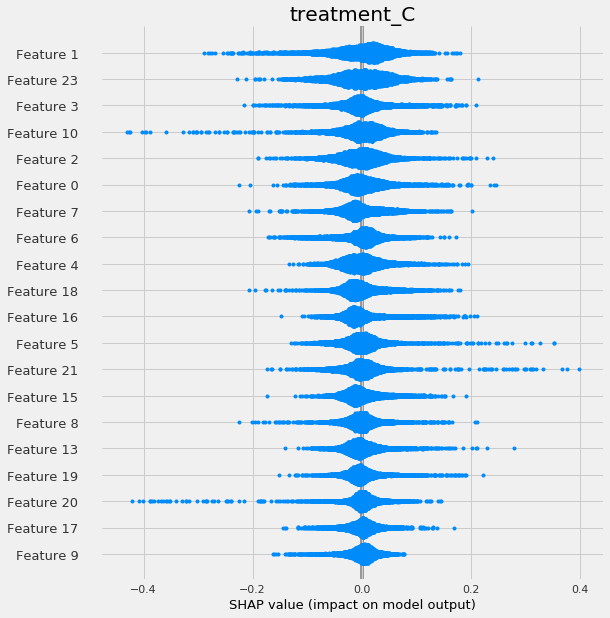

In [50]:
# with providing shap_dict
rlearner.plot_shap_values(shap_dict=shap_rlearner)

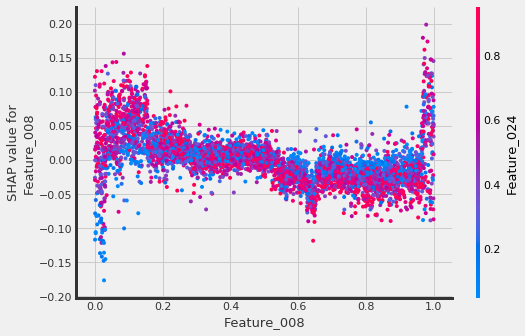

In [51]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
rlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=8,
                              X=X,
                              treatment=w_multi,
                              interaction_idx='auto',
                              shap_dict=shap_rlearner)

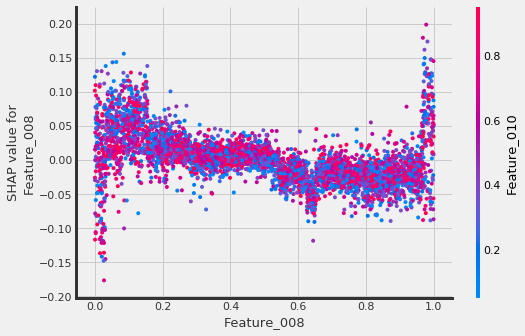

In [52]:
# interaction_idx set to specific index
rlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=8,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=10,
                              shap_dict=shap_rlearner)

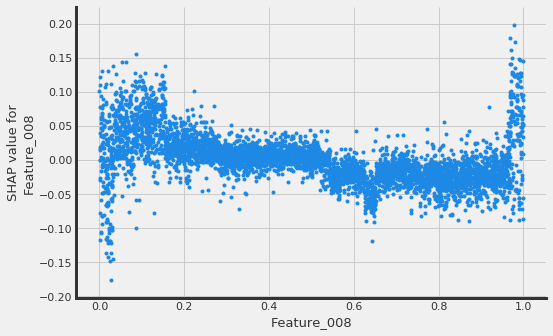

In [53]:
# interaction_idx set to None (no color coding for interaction effects)
rlearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=8,
                              X=X,
                              treatment=w_multi,
                              interaction_idx=None,
                              shap_dict=shap_rlearner)